# Figure 2 #

In [2]:
#Packages
import numpy as np
import matplotlib.pyplot as pl
import matplotlib
from numpy import random
from numpy.random import randn
import pandas as pd
from scipy.integrate import solve_ivp
from numpy import linalg as LA

In [ ]:
##### Functions #####

#Model equations for the unicellular ancestor alone
def ES1(t,f,r1A,r1B,g,m1AB,m1BA):
    #variables
    vA = f[0]
    vB = f[1]
    #equations
    dvA = (r1A)*vA - g*vA**2 - m1AB*vA + m1BA*vB
    dvB = (r1B)*vB - g*vB**2 + m1AB*vA - m1BA*vB
    
    return [dvA,dvB]

#Calculation of the Jacobian matrix eigenvalues for a multicellular mutant attempting to invade.
def EigM(vA,vB,pars):

    r1A,r1B,r2A,r2B,g,m1AB,m1BA,m2AB,m2BA=pars

    M=np.array([[ -(r1A) -g*vA -m1AB, m1BA, 2*r2A, 0],
               [ m1AB, -(r1B) -g*vB -m1BA, 0, 2*r2B],
                [ r1A, 0, - g*vA - m2AB, m2BA],
                [ 0, r1B, m2AB, - g*vB - m2BA]])

    return LA.eig(M)

######## Main code ########

Sample_size=10000

#Migration regimes:
m_value_str=['low','mid','high']
m_range=[1/50,1,50]

#Loop over the different migration regimes
for m_ii in [0,1,2]:
    
    g=1 #\gamma

    #Setting the lists to be filled with sampled data
    R2_l=np.zeros(Sample_size)
    C2_l=np.zeros(Sample_size)
    R1_l=np.zeros(Sample_size)
    C1_l=np.zeros(Sample_size)
    
    qA_l=np.zeros(Sample_size)
    p1A_l=np.zeros(Sample_size)
    p2A_l=np.zeros(Sample_size)
    
    m1AB_l=np.zeros(Sample_size)
    m1BA_l=np.zeros(Sample_size)
    m2AB_l=np.zeros(Sample_size)
    m2BA_l=np.zeros(Sample_size)
    
    
    m_l=np.zeros(Sample_size)
    
    r1A_l=np.zeros(Sample_size)
    r2A_l=np.zeros(Sample_size)
    r1B_l=np.zeros(Sample_size)
    r2B_l=np.zeros(Sample_size)
    
    w_l=np.zeros(Sample_size)
    count=-1

    #Loop until we have enough samples
    while count<=Sample_size-2:
        count+=1

        #Total growth rate: 
        r=1
        #Total migration rate: (depends on the migration regime)
        m=m_range[m_ii]

        #Randomly sample the growth rates
        rps=[np.random.uniform() for i in range(4)]
    
        r1A=r*rps[0]/sum(rps)
        r1B=r*rps[1]/sum(rps)
    
        r2A=r*rps[2]/sum(rps)
        r2B=r*rps[3]/sum(rps)

        #Check that there are no direct benefits
        if r1A<r2A or r1B<r2B:
            continue
        
        r1A_l[count]=r1A
        r1B_l[count]=r1B
        r2A_l[count]=r2A
        r2B_l[count]=r2B

        #Randomly sample the migration rates
        
        mps=[np.random.uniform() for i in range(4)]
    
        m1AB=m*mps[0]/sum(mps)
        m1BA=m*mps[1]/sum(mps)
    
        m2AB=m*mps[2]/sum(mps)
        m2BA=m*mps[3]/sum(mps)
        
        m1AB_l[count]=m1AB
        m1BA_l[count]=m1BA
        m2AB_l[count]=m2AB
        m2BA_l[count]=m2BA
        
        m=m1AB+m1BA+m2AB+m2BA
     
        m_l[count]=m
        
        #Simulate the ancestor until equilibrium
        ts0=np.linspace(0,3000000,1000)
        q0 = [(r1A)/g,(r1B)/g]
        qsol = solve_ivp(ES1,(ts0[0],ts0[-1]),q0,args=(r1A,r1B,g,m1AB,m1BA), dense_output=True,method='LSODA')
        qs= qsol.sol(ts0)
        qs_0=qs[:,-1]
    
        #Calculate the equilibrium values for
        vA=qs_0[0] # Number of ancestral cells in A
        vB=qs_0[1] # Number of ancestral cells in B
        qA= vA/(vA+vB) # Proportion of ancestral cells in A
        qB=1-qA        # Proportion of ancestral cells in B
    
    
        #Calculate the maximum eigenvalue of the Jacobian matrix for the multicellular mutant attempting to invade.
        pars=[r1A,r1B,r2A,r2B,g,m1AB,m1BA,m2AB,m2BA]
        e_val, e_vec = EigM(vA,vB,pars)
        i_max=list(e_val).index(max(e_val))
        ev=e_val[i_max]

        #Calculate the:
        uAe=abs(e_vec[:,i_max][0]) # Number of 2+1 single cells in A
        uBe=abs(e_vec[:,i_max][1]) # Number of 2+1 single cells in B
    
        UAe=abs(e_vec[:,i_max][2]) # Number of 2+1 groups in A
        UBe=abs(e_vec[:,i_max][3]) # Number of 2+1 groups in B
    
        p1A=uAe/(uAe+uBe) # Proportion of 2+1 single cells in A
        p1B=1-p1A # Proportion of 2+1 single cells in B
        p2A=UAe/(UAe+UBe) # Proportion of 2+1 groups in A
        p2B=1-p2A # Proportion of 2+1 groups in B
        
        # Record the values
        qA_l[count]=qA
        p1A_l[count]=p1A
        p2A_l[count]=p2A
        
        # Calculate R1, R2, C1, C2
        R1= (p1A*r1A + p1B*r1B)/(qA*r1A + qB*r1B)
        R2= (p2A*r2A + p2B*r2B)/(qA*r1A + qB*r1B)
        C1= (p1A*qA + p1B*qB)/(qA**2 + qB**2)
        C2= (p2A*qA + p2B*qB)/(qA**2 + qB**2)
        
        R1_l[count]=R1
        R2_l[count]=R2
        C1_l[count]=C1
        C2_l[count]=C2
        
    # Save the results into a dataframe
    d_l={"R1": R1_l,"C1": C1_l,"R2": R2_l,"C2": C2_l,"m": m_l,"m1AB":m1AB_l,"m1BA":m1BA_l,"m2AB":m2AB_l,"m2BA":m2BA_l,
        "qA":qA_l,"p1A":p1A_l,"p2A":p2A_l,"r1A":r1A_l,"r1B":r1B_l,"r2A":r2A_l,"r2B":r2B_l,"win":w_l}
    
    df_l=pd.DataFrame(d_l)
    
    df_l.to_csv('Fig2-multicell-'+m_value_str[m_ii]+'_new.csv',index = False)

In [ ]:
# Load the data for plotting

df=pd.read_csv('Data/Fig2-multicell-low.csv')
R1_low=df.R1.to_numpy()[:10000]
R2_low=df.R2.to_numpy()[:10000]
C1_low=df.C1.to_numpy()[:10000]
C2_low=df.C2.to_numpy()[:10000]
m_low=df.m.to_numpy()[:10000]

df=pd.read_csv('Data/Fig2-multicell-mid.csv')
R1_mid=df.R1.to_numpy()[:10000]
R2_mid=df.R2.to_numpy()[:10000]
C1_mid=df.C1.to_numpy()[:10000]
C2_mid=df.C2.to_numpy()[:10000]
m_mid=df.m.to_numpy()[:10000]

df=pd.read_csv('Data/Fig2-multicell-high.csv')
R1_high=df.R1.to_numpy()[:10000]
R2_high=df.R2.to_numpy()[:10000]
C1_high=df.C1.to_numpy()[:10000]
C2_high=df.C2.to_numpy()[:10000]
m_high=df.m.to_numpy()[:10000]


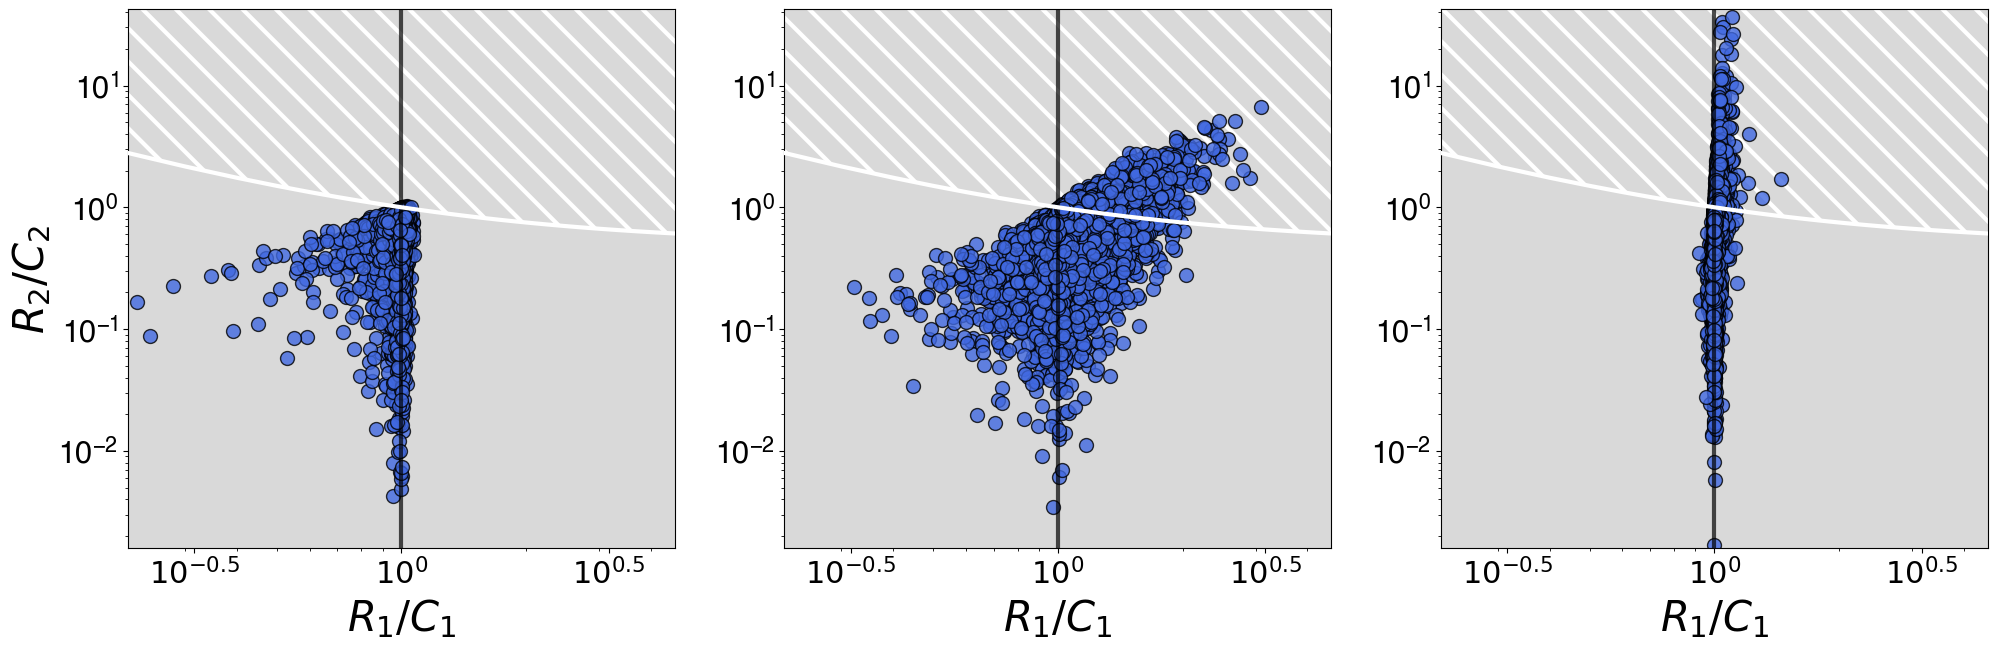

In [4]:
# Plotting the results

hfont = {'fontname':'Helvetica'}
pl.rcParams['hatch.linewidth'] = 3
xx=np.linspace(0.0001,1000,10000)


fig1, axes = pl.subplots(1, 3,figsize=(24,7))

ax1=axes[0]
ax2=axes[1]
ax3=axes[2]


plot=ax1.scatter(R1_low/C1_low,R2_low/C2_low,c="royalblue",s=100, edgecolor='black',alpha=0.8)

plot=ax2.scatter(R1_mid/C1_mid,R2_mid/C2_mid,c="royalblue",s=100,edgecolor='black',alpha=0.8)

plot=ax3.scatter(R1_high/C1_high,R2_high/C2_high,c="royalblue",s=100, edgecolor='black',alpha=0.8)


x4=np.linspace(0,100,10000)
xx1=np.linspace(1,1000,10000)

ax1.set_xlim(10**(-0.66),10**(0.66))
ax1.set_ylim(10**(-2.8),42.21418329876664)

ax1.fill_between(x4,x4*0 -0.00042277150293700547,x4*0+42.21418329876664,lw=0,color='k',alpha=0.15,zorder=0)
ax1.fill_between(xx,1/2 +1/(2*xx),xx*0 +42.21418329876664+10,color="none", edgecolor='white',hatch='\\',alpha=1,linewidth=0,zorder=0)
ax1.plot(xx,1/2 +1/(2*xx),color='white',lw=3,zorder=3)
ax1.plot([1,1],[10**(-2.8),42.21418329876664],color='k',lw=3,zorder=2,alpha=0.7)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_xticks([10**(-0.5), 1, 10**(0.5)],[r'$10^{-0.5}$',r'$10^{0}$',r'$10^{0.5}$'])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.set_xticks([10**(-0.5), 1, 10**(0.5)],[r'$10^{-0.5}$',r'$10^{0}$',r'$10^{0.5}$'])


ax2.set_xlim(10**(-0.66),10**(0.66))
ax2.set_ylim(10**(-2.8),42.21418329876664)

ax2.fill_between(x4,x4*0 -0.00042277150293700547,x4*0+42.21418329876664,lw=0,color='k',alpha=0.15,zorder=0)
ax2.fill_between(xx,1/2 +1/(2*xx),xx*0 +42.21418329876664+10,color="none", edgecolor='white',hatch='\\',alpha=1,linewidth=0,zorder=0)
ax2.plot(xx,1/2 +1/(2*xx),color='white',lw=3,zorder=3)
ax2.plot([1,1],[10**(-2.8),42.21418329876664],color='k',lw=3,zorder=2,alpha=0.7)

ax2.set_yscale('log')
ax2.set_xscale('log')

ax2.set_xticks([10**(-0.5), 1, 10**(0.5)],[r'$10^{-0.5}$',r'$10^{0}$',r'$10^{0.5}$'])
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax2.set_xticks([10**(-0.5), 1, 10**(0.5)],[r'$10^{-0.5}$',r'$10^{0}$',r'$10^{0.5}$'])


ax3.set_xlim(10**(-0.66),10**(0.66))
ax3.set_ylim(10**(-2.8),42.21418329876664)

ax3.fill_between(x4,x4*0 -0.00042277150293700547,x4*0+42.21418329876664,lw=0,color='k',alpha=0.15,zorder=0)
ax3.fill_between(xx,1/2 +1/(2*xx),xx*0 +42.21418329876664+10,color="none", edgecolor='white',hatch='\\',alpha=1,linewidth=0,zorder=0)
ax3.plot(xx,1/2 +1/(2*xx),color='white',lw=3,zorder=3)
ax3.plot([1,1],[10**(-2.8),42.21418329876664],color='k',lw=3,zorder=2,alpha=0.7)

ax3.set_yscale('log')
ax3.set_xscale('log')

ax3.set_xticks([10**(-0.5), 1, 10**(0.5)],[r'$10^{-0.5}$',r'$10^{0}$',r'$10^{0.5}$'])
ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax3.set_xticks([10**(-0.5), 1, 10**(0.5)],[r'$10^{-0.5}$',r'$10^{0}$',r'$10^{0.5}$'])


ax1.set_ylabel('$R_2/C_2$',fontsize=30,rotation=90,multialignment='center',**hfont)
ax1.set_xlabel('$R_1/C_1$',fontsize=30,multialignment='center')
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
ax1.tick_params(labelsize=22)

ax2.set_xlabel('$R_1/C_1$',fontsize=30,multialignment='center',**hfont)
ax2.get_xaxis().get_major_formatter().labelOnlyBase = False
ax2.tick_params(labelsize=22)

ax3.set_xlabel('$R_1/C_1$',fontsize=30,multialignment='center',**hfont)
ax3.get_xaxis().get_major_formatter().labelOnlyBase = False
ax3.tick_params(labelsize=22)

for tick in ax1.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Helvetica")
for tick in ax2.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Helvetica")
for tick in ax3.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Helvetica")


fig1.savefig(r"Figures/Figure2_python.png",bbox_inches='tight')
fig1.savefig(r"Figures/Figure2_python.pdf",bbox_inches='tight')
fig1.savefig(r"Figures/Figure2_python.svg",bbox_inches='tight')

# Figure 3a #

In [5]:
#Packages
import numpy as np
import matplotlib.pyplot as pl
import matplotlib


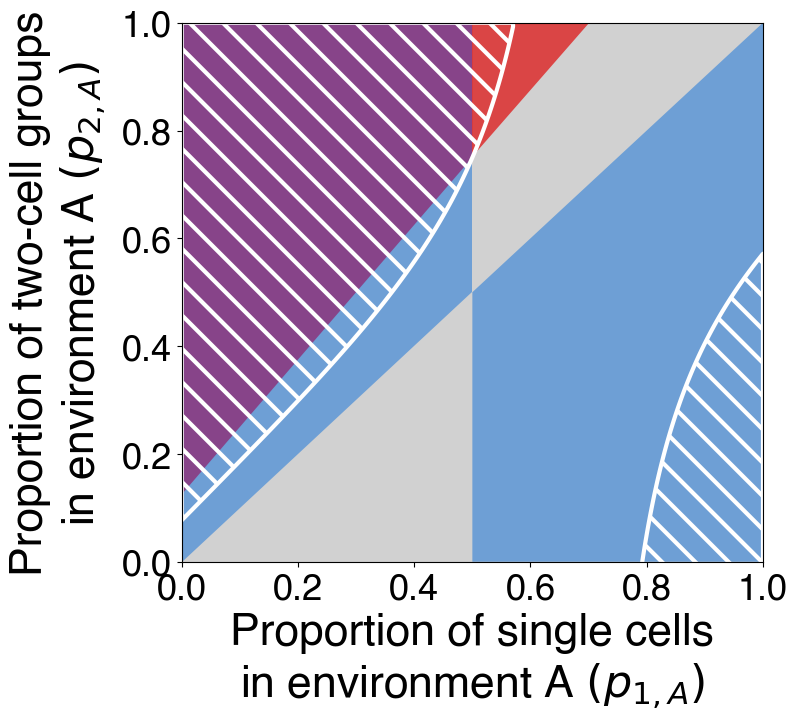

In [ ]:
hfont = {'fontname':'Helvetica'}
pl.rcParams['hatch.linewidth'] = 3.

def f(x,tau,sigma):
    return (1/tau)*x + (sigma/(1-sigma))*(1/tau -1) 

def g(y,tau,sigma):
    return tau*y - tau*(sigma/(1-sigma))*(1/tau -1) 

def h(x,tau,sigma):
    return (((1-x)/(x**2 + (1-x)**2)) -(tau*sigma)/(x*(1-sigma) +sigma))/(tau*(1-sigma)/(x*(1-sigma) +sigma) -((2*x -1)/(x**2 +(1-x)**2)))


tau=0.8
sigma=1/3

fig, ax = pl.subplots(figsize=(7.5,7))

x4=np.linspace(0,1,10000)
ax.fill_between(x4,x4*0 -1,x4*0+2,lw=0,color='#d1d1d1ff',zorder=0)
  
ax.fill("j", "k", '#2C7FD8',alpha=0.6,
         data={"j": [0, 0,  0.5,0.5], 
               "k": [0, 1, 1,0.5]})  

ax.fill("j", "k", '#2C7FD8',alpha=0.6,
         data={"j": [1, 0.5,0.5,1], 
               "k": [0,   0,0.5,1]}) 


ax.fill("j", "k", '#8E2E76',alpha=0.8,
         data={"j": [0, 0             ,0.5             ,0.5], 
               "k": [1, f(0,tau,sigma),f(0.5,tau,sigma),1]})  

ax.fill("j", "k", '#DD2222',alpha=0.8,
         data={"j": [0.5             ,0.5, g(1,tau,sigma)], 
               "k": [f(0.5,tau,sigma),1  , 1             ]})


x1=np.linspace(0,0.57,10000)
ax.fill_between(x1,x1*0 +1,h(x1,tau,sigma),color="none", edgecolor='white',hatch='\\',alpha=1,linewidth=3.,zorder=2)

x2=np.linspace(0.7,1,10000)
ax.fill_between(x2,x2*0 -1,h(x2,tau,sigma),color="none", edgecolor='white',hatch='\\',alpha=1,linewidth=3.,zorder=2)

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_ylabel('Proportion of two-cell groups\nin environment A $(p_{2,A})$',fontsize=32,rotation=90,labelpad=10,multialignment='center',**hfont)
ax.set_xlabel('Proportion of single cells\nin environment A $(p_{1,A})$',fontsize=32,multialignment='center',**hfont)
ax.get_xaxis().get_major_formatter().labelOnlyBase = False
ax.tick_params(labelsize=26)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")

pl.show()



fig.savefig(r"Figures/Figure3a.pdf",bbox_inches='tight')
fig.savefig(r"Figures/Figure3a.png",bbox_inches='tight')
fig.savefig(r"Figures/Figure3a.svg",bbox_inches='tight')

# Supplementary Figure 1 #

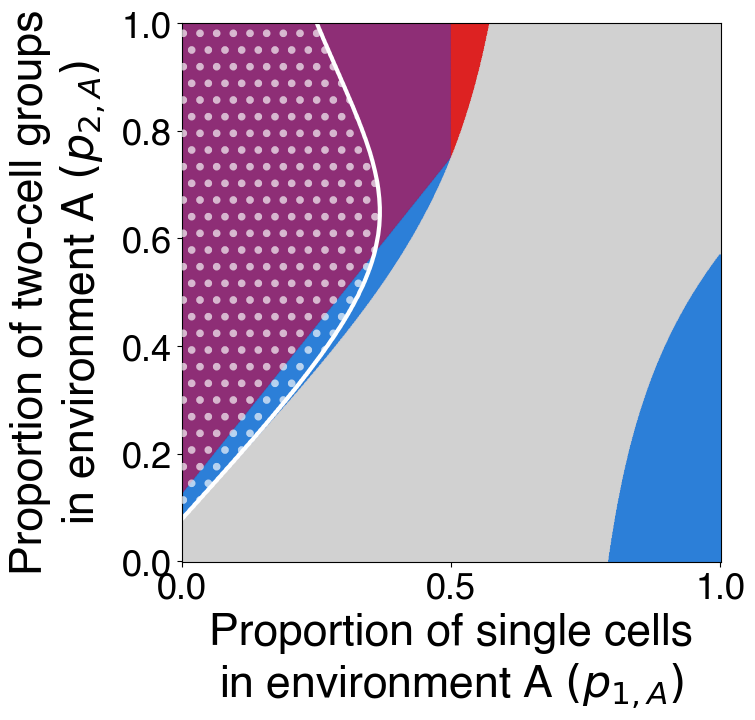

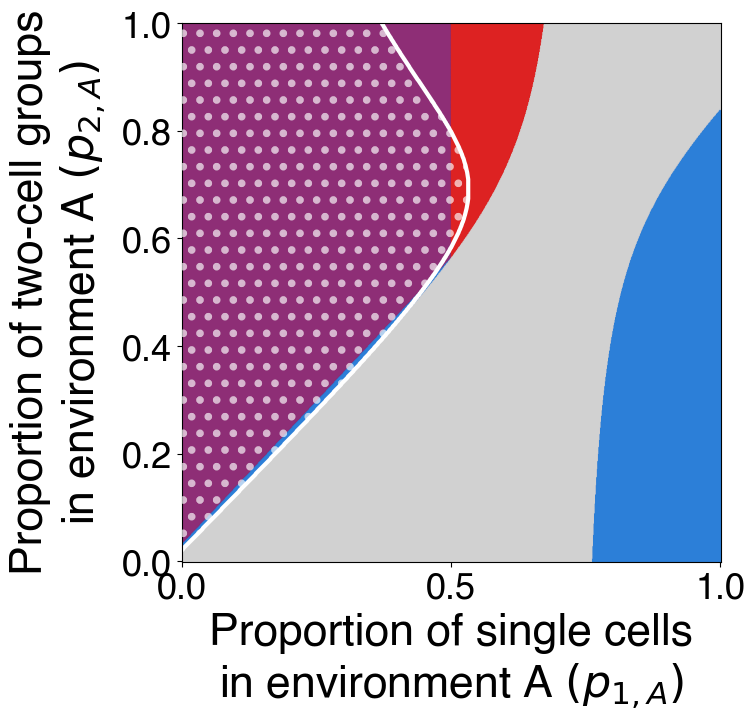

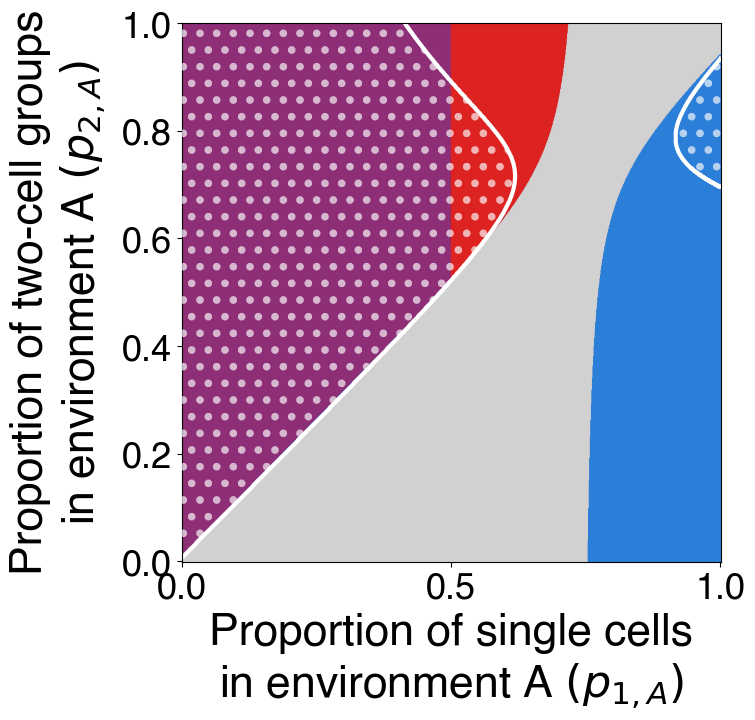

In [5]:
### Full figure analysis and Plotting

# Importing libraries 
import matplotlib 
import matplotlib.pyplot as pl
pl.rcParams['hatch.linewidth'] = 2
hfont = {'fontname':'Helvetica'}


#Packages
import numpy as np
from numpy import random
from numpy.random import randn
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from numpy import linalg as LA


#Model equations for a multicellular mutant in isolation
def ES3(t,f,b1A,b1B,b2A,b2B,gamma,qA,p2A):
    #parameters

    #variables
    v = f[0]
    w = f[1]
    
    qB=1-qA
    p2B=1-p2A
    
    b1=b1A*qA + b1B*qB
    b2=b2A*p2A + b2B*p2B
    
    dv = 2*b2*w - b1*v - gamma*v*((qA**2 + qB**2)*v+2*(p2A*qA + p2B*qB)*w)
    
    dw= b1*v -gamma*w*((p2A*qA + p2B*qB)*v+2*(p2A**2 + p2B**2)*w)
    
    return[dv,dw]
    


gamma=1
for tau in [0.8,0.94,0.98]:
    
    sigma=1/3
    b1A=15
    b1B= sigma*b1A
    b2A=tau*b1A
    b2B=tau*b1B
    
    x=np.linspace(0,1,1000)
    Mx_l=[]
    Mp_l=[]
    Mx=np.zeros((len(x),len(x)))
    Mp=np.zeros((len(x),len(x)))
    
    coex=0
    dom=0
    
    for iq in range(len(x)):
        for ip in range(len(x)):
            
            qA=x[iq]
            p2A=x[ip]
            
            qB=1-qA
            p2B=1-p2A
            b1=b1A*qA + b1B*qB
            b2=b2A*p2A + b2B*p2B
            
            if tau*(p2A*(1-sigma) + sigma)/(qA*(1-sigma) + sigma)> (p2A*qA +p2B*qB)/(qA**2 + qB**2):
                
                
                ts0=np.linspace(0,3000000,1000)
    
                q0 = [b1/gamma,b2/gamma]
                #parameters
                #calls integrator
                qsol = solve_ivp(ES3,(ts0[0],ts0[-1]),q0,args=(b1A,b1B,b2A,b2B,gamma,qA,p2A), dense_output=True,method='LSODA')
                qs= qsol.sol(ts0)
                qs_0=qs[:,-1]
    
                v=qs_0[0]
                w=qs_0[1]
    
    
                if tau*(p2A*(1-sigma) + sigma)/(qA*(1-sigma) + sigma)> 1 and 1 <= (p2A*qA +p2B*qB)/(qA**2 + qB**2):
                    Mp[iq][ip]=2
                elif tau*(p2A*(1-sigma) + sigma)/(qA*(1-sigma) + sigma)<= 1 and 1 > (p2A*qA +p2B*qB)/(qA**2 + qB**2):
                    Mp[iq][ip]=1
                else:
                    Mp[iq][ip]=3
                
                if b1/gamma > (qA**2 + qB**2)*v + 2*(p2A*qA + p2B*qB)*w:   
                    Mx[iq][ip]=1
                    coex+=1
                else:
                    Mx[iq][ip]=2
                    dom+=1
        
    
    pl.rcParams['hatch.linewidth'] = 3
    pl.rcParams['hatch.color'] = 'white'
    hfont = {'fontname':'Helvetica'}
    
    fig, ax = pl.subplots(figsize=(7.5,7))
    
    from matplotlib.colors import ListedColormap
    qAl,p2Al= np.meshgrid(x,x, indexing='xy')
    
    #plot=pl.pcolormesh( p2Al,qAl, Mp,cmap=ListedColormap(['grey','green','#DD3497']),shading='gouraud')
    plot=pl.pcolormesh( p2Al,qAl, Mp,cmap=ListedColormap(['#d1d1d1ff','#2C7FD8','#DD2222','#8E2E76']),shading='gouraud')
    
    
    Mxm = np.ma.masked_less_equal(Mx,1)
    pl.pcolor(p2Al,qAl, Mxm, hatch='.',alpha=0.,zorder=4)
    ax.set_aspect(1)
    
    
    
    x_tr=[]
    y_tr=[]
    
    for i in range(len(Mx)):
        for j in range(len(Mx)):
            if j!=0:
                if (Mx[i][j]-Mx[i][j-1])!=0 and (Mx[i][j]==2 or Mx[i][j-1]==2):
                    x_tr.append(qAl[i][j]) 
                    y_tr.append(p2Al[i][j]) 

    if tau==0.98:
        y_tr_o, x_tr_o = zip(*sorted(zip(x_tr[:825],y_tr[:825])))
        y_tr_o2, x_tr_o2 = zip(*sorted(zip(x_tr[825:],y_tr[825:])))
        ax.plot(x_tr_o,y_tr_o,color='white',lw=3)
        ax.plot(x_tr_o2,y_tr_o2,color='white',lw=3)
    else:
        y_tr_o, x_tr_o = zip(*sorted(zip(x_tr,y_tr)))
        ax.plot(x_tr_o,y_tr_o,color='white',lw=3)
    
    
    
    ax.set_ylabel('Proportion of two-cell groups\nin environment A $(p_{2,A})$',fontsize=32,rotation=90,labelpad=10,multialignment='center',**hfont)
    ax.set_xlabel('Proportion of single cells\nin environment A $(p_{1,A})$',fontsize=32,multialignment='center',**hfont)
    ax.get_xaxis().get_major_formatter().labelOnlyBase = False
    ax.tick_params(labelsize=26)
    
    for tick in ax.get_xticklabels():
        tick.set_fontname("Helvetica")
    for tick in ax.get_yticklabels():
        tick.set_fontname("Helvetica")

    pl.show()
    fig.savefig(r"Figures/Figure_Sup_tau="+str(tau*100)+".png",bbox_inches='tight')
    fig.savefig(r"Figures/Figure_Sup_tau="+str(tau*100)+".pdf",bbox_inches='tight')
    fig.savefig(r"Figures/Figure_Sup_tau="+str(tau*100)+".svg",bbox_inches='tight')

    Mx_l.append(Mx)
    Mx_l.append(Mp)


# Figure 4d and S3 #

In [ ]:
## Packages and functions

from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as pl
from numpy import random
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import fsolve

def Np1_simulation(t,u,r,pA,pB,g,NS,l,Life_cycles):
    #u = variable list
    #du = du/dt  
    du=np.zeros(len(u))

    #t = time
    #l[i] = number of cells in the group represented by u[i]
    #Life_cycles = list of the present life cycles in the system
    # if Life_cycles=[i,j,w], that means that life cycles i+1, j+1 and w+1 are present

    #r,pA,pB,g,NS = parameters
    
    K_up=0 #Number of cells in the upper layer
    K_low=0 #Number of cells in the lower layer

    for i_K in range(len(u)):
        if pA[l[i_K]]==1:
            K_up += l[i_K]*u[i_K]
        else:
            K_low += l[i_K]*u[i_K]

    
    w=0 #Life cycle index
    ww=0 #Group size index
    
    while w<len(Life_cycles): 

        Nn=Life_cycles[w]
        
        #If the life cycle is 1+1 (unicellular)
        if Nn==1:
            du[ww] = r[1]*u[ww] - u[ww]*g*K_up

        #For every other life cycle:
        else:
            if Nn<NS: #If the life cycle is small:
                du[ww] = -r[1]*u[ww] - u[ww]*g*K_up + Nn*r[Nn]*u[ww+Nn-1] #Single cell life stage i=1

                for i in range(1,Nn-1):#Group life stages 
                    du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_up)*u[ww+i] 

                du[ww+Nn-1] = (Nn-1)*r[Nn-1]*u[ww+Nn-2] -g*K_up*u[ww+Nn-1] #Final life stage

            else: #If the life cycle is intermediate or large:
                du[ww] = -r[1]*u[ww] - u[ww]*g*K_up + Nn*r[Nn]*u[ww+Nn-1] #Single cell life stage i=1

                for i in range(1,NS-1):#Group life stages in the upper layer
                    du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_up)*u[ww+i] 

                for i in range(NS-1,Nn-1):#Group life stages in the lower layer
                    du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_low)*u[ww+i] 

                du[ww+Nn-1] = (Nn-1)*r[Nn-1]*u[ww+Nn-2] -g*K_low*u[ww+Nn-1] #Final life stage

        #Next life cycle starting at index ww       
        w+=1 
        ww+=Nn 

    return du


def R0_calculation(u_eq,r,pA,pB,g,l,NS,NE):

    #u_eq= variable list in the stationary state

    K_up=0 #Number of cells in the upper layer
    K_low=0 #Number of cells in the lower layer
    for i_K in range(len(u_eq)):
        if pA[l[i_K]]==1:
            K_up += l[i_K]*u_eq[i_K]
        else:
            K_low += l[i_K]*u_eq[i_K]

    C_l=[0] #competition experienced by a group of size "i". There are no groups of size 0, then C_l[0]=0
    for i_C in np.arange(NE)+1:
        if pA[i_C]==1:
            C_l.append(g*K_up)
        else:
            C_l.append(g*K_low)

    R0=[0,r[1]/(C_l[1])] #R0[i]= R0 of a i+1 life cycle. 0+1 does not exist, then R0[0]= 0. R0[1]= r[1]/Cl[0].

    #The R0's of the other life cycles can be obtained iteratevely:
    if K_low!=0:
        for n in range(2,NE+1):
            R0_n=(R0[n-1]/((n-1)*r[n-1]/(C_l[n-1])))*((n-1)*r[n-1]/((n-1)*r[n-1] + C_l[n-1]))*(n*r[n]/(C_l[n]))
            R0.append(R0_n)

    elif K_low==0 and r[NS]>0: #If there are no groups in the lower layer, the basic reproduction number for n>NS goes to infinity as long as r>0.
          #Since we only care whether R0>1 or R0<1, we set R0[i>=NS]=2
        for n in range(2,NS):
            R0_n=(R0[n-1]/((n-1)*r[n-1]/(C_l[n-1])))*((n-1)*r[n-1]/((n-1)*r[n-1] + C_l[n-1]))*(n*r[n]/(C_l[n]))
            R0.append(R0_n)
        for n in range(NS,NE+1):
            R0.append(2)

    else: #Finally, if r=0 and K_low=0, R0[i>NS]=0
        for n in range(2,NS):
            R0_n=(R0[n-1]/((n-1)*r[n-1]/(C_l[n-1])))*((n-1)*r[n-1]/((n-1)*r[n-1] + C_l[n-1]))*(n*r[n]/(C_l[n]))
            R0.append(R0_n)
        for n in range(NS,NE+1):
            R0.append(0)

    return R0

def Mutations(NE,R0,Life_cycles,err):

    #err = 10^-10 = small window for numerical error

    #Create a list of possible invaders based: being able to invade (R0[i]>=1), and not being currently present in the system (i is not in Life_cycles). 
    Possible_invaders=[]
    for i in range(1,NE+1):
        if R0[i]>1-err and (i not in Life_cycles):
            Possible_invaders.append(i)

    if len(Possible_invaders)==1:
        i_mut=0
    else:
        i_mut=random.randint(0, len(Possible_invaders)-1)
        
    return Possible_invaders[i_mut] #Sample one life cycle randomly from the list of potential invaders

In [ ]:
# Eco-evolutionary algorithm

for rF in [0,1,3,5,6]:
    
    NU_l=np.arange(0,81)


    for NU in NU_l: 

    ##Parameters:
        DeltaN=4
        NL= NU-DeltaN
        rO=6.8
        NS=15
        g=1#gamma
        #Maximal group size in the simulations=80
        NE=80


        ##Spatial dirtribution:
        #pA[i] = proportion of groups of size "i" in environment A (i.e., the upper layer)
        pA=np.zeros(NE+1)
        for i in range(1,NS):
            pA[i]=1
        for i in range(NS,NE+1):
            pA[i]=0
        #pB[i] = 1 - pA[i] = proportion of groups of size "i" in environment B (i.e., the lower layer)
        pB=1-pA
        # We do not consider groups of size 0: pA[0]=pB[0]=0 


        ##Growth rates:

        #If NU<DeltaN => No oxygen in the lower layer
        if NL<0:
            DeltaN=NU
            NL=0

        #Creating the growth rate arrays
        rA=np.zeros(NE+1) #rA[i]= Growth rate of a cell in a group of size "i" in environment A (i.e., the upper layer)
        rB=np.zeros(NE+1) #rB[i]= Growth rate of a cell in a group of size "i" in environment B (i.e., the lower layer)
        r=np.zeros(NE+1) #r[i]= Average growth rate (across both environments) of a cell in a group of size "i"
        # We do not consider groups of size 0: rA[0]=rB[0]=r[0]=0 

        #Assigning values to the growth rate arrays
        for i in range(1,NE+1):
            if i<=NU:
                rA[i]= rO
            else:
                rA[i]=(rO*NU + rF*(i-NU))/i

            if i<=NL:
                rB[i]= rO
            else:
                rB[i]=(rO*(NL) + rF*(i-NL))/i

            r[i]= rA[i]*pA[i] + rB[i]*pB[i]



        err= 10**(-8) #err = 10^-8 = small window for numerical error
        # R0>1-err corresponds to R0>=1,
        # R0>1+err corresponds to R0>1.

        N_tries=1
        for idx_tries in range(N_tries):
            #The initial community cosnsists of a resident 1+1 life cycle. 

            # Cells cannot survive when rF=0 and NU=0. In this scenario, the result is an empty ESC
            if rF>0 or (rF==0 and NU>1):
                Life_cycles=[1]
                l=[1]

                #Initial condition
                u0 = np.zeros(1)
                u0[0]=(r[1])/g #Equilibrium abundance of 1+1 in isolation
                u_eq=u0
                R0=R0_calculation(u_eq,r,pA,pB,g,l,NS,NE)
        
            
                R0_max="Invader"
                while R0_max=="Invader":

                    ##Introduce a new mutant life cycle M_N
                    M_N=Mutations(NE,R0,Life_cycles,err) 
                    #print(M_N)
                    Life_cycles.append(M_N) #Append life 

                    
                    ##Initial conditions:
                    #u0[i] = initial condition for variable i 
                    #u_eq[i] = equilibrium value of variable i found in the previous iteration
                    #u_eq_num[i] = equilibrium value of the number of cells belonging to life cycle i+1 found in the previous iteration 
                    u0 = np.zeros(len(u_eq)+M_N)
                    for i in range(len(u_eq)): #q0 = equilibrium state found on the previous iteration (u_eq) + small abundance of mutant single cells.
                        u0[i]=u_eq[i]
                    u0[len(u_eq)]=sum(l*u_eq)*0.01 #The introduces abundance of mutants correspond to 1% of the resident cell population.


                    ##Useful lists:
                    #lc= Max Size of each life cycle strategy
                    lc=[]
                    for n in Life_cycles:
                        for i in range(1,n+1):
                            lc.append(n)
                    lc=np.array(lc)
                    #l = Size of each life cycle strategy
                    l=[]
                    for n in Life_cycles:
                        for i in range(1,n+1):
                            l.append(i)
                    l=np.array(l)

                    
                    ##Numerical integration of the dynamics until reaching equilibrium
                    ts0=np.linspace(1,500000000,1000) #Define time interval
                    usol = solve_ivp(Np1_simulation,(ts0[0],ts0[-1]),u0,args=(r,pA,pB,g,NS,l,Life_cycles), dense_output=True,method='LSODA')
                    u_t= usol.sol(ts0)#time series
                    u_eq=u_t[:,-1]
                
                    ##Calculate R0
                    R0=R0_calculation(u_eq,r,pA,pB,g,l,NS,NE)

                    ##Drop life cycles that were competitively excluded (i.e., if N+1 is in Life_cycles and R0[N]<0):
                    Life_cycles_new=[] #Life_cycle list after dropping the excluded life cycles
                    u_eq_new=[] #u_eq list after dropping the excluded life cycles
                    for i in range(len(Life_cycles)):
                        i_lc=Life_cycles[i]
                        if R0[i_lc]>=1-err:
                            Life_cycles_new.append(i_lc)
                            i_pos=list(lc).index(i_lc)
                            for j in range(i_pos,i_pos+i_lc):
                                u_eq_new.append(u_eq[j])
                    #Update lists
                    Life_cycles=Life_cycles_new
                    u_eq=np.array(u_eq_new)

                    ##Useful lists:
                    #lc= Max Size of each life cycle strategy
                    lc=[]
                    for n in Life_cycles:
                        for i in range(1,n+1):
                            lc.append(n)
                    lc=np.array(lc)
                    #l = Size of each life cycle strategy
                    l=[]
                    for n in Life_cycles:
                        for i in range(1,n+1):
                            l.append(i)
                    l=np.array(l)
                    

                    ##Check if this equilibrium can disrupted by an invader (i.e., R0>1 for any i that is not in the Life_cycles list).
                    #If such life cycles cannot be found, we have reacxhed an Evolutionarily Stable Community (ESC);
                    # then R0_max="No invader" and the "while-loop" is complete. 
                    R0_max="No Invader"
                    for i in range(1,NE+1):
                        if R0[i]>1+err:
                            R0_max="Invader" #If any non-resident can invade, R0_max="Invader" and the loop continues
                    #Note that, for the purpose of completing this eco-evo algorithm, we are only concerned with life cycles that can invade 
                    # non-neutrally (i.e. R0>1 rather than R0>=1). 
                    #Neutral invaders (R0=1) can invade but will remain in small abundances, since our model does not acoount for stochasticity.



                ##After the ESC is reached, compute all life cycles that can coexist in it (including neutral coexistence, i.e., R0=1).
                ESC=[]
                for i in range(1,NE+1):
                    if R0[i]>1-err:
                        ESC.append(i)
                print(ESC)
                df=pd.DataFrame(ESC)
                df.to_csv("Data/Data_Cell_np1/Cells_"+str(NU)+"_"+str(idx_tries)+"_"+str(rF)+".csv",index=False,header=False)

            elif rF==0 and NU==0:

                ESC=[]
                df=pd.DataFrame(ESC)
                df.to_csv("Data/Data_Cell_np1/Cells_"+str(NU)+"_"+str(idx_tries)+"_"+str(rF)+".csv",index=False,header=False)
            
            else: # When rF=0 and NU=1, there is no oxygen in the lower layer (and no cell can survive there)
                  # The unicellular ancestor, then, is the small life cycle with the highest growth rate and the ESC is composed by 1+1 alone.
                ESC=[1]
                df=pd.DataFrame(ESC)
                df.to_csv("Data/Data_Cell_np1/Cells_"+str(NU)+"_"+str(idx_tries)+"_"+str(rF)+".csv",index=False,header=False)
            
                

In [ ]:
#Joining results of each rF scenario

for rF in [0,1,3,5,6]:
    Results=[]
    Type="Cells"
    for NU in range(0,81):

        N_tries=1

        for tries in range(N_tries):
            if rF==0 and NU==0:
                Results.append([])

            else:
                df=pd.read_csv("Data/Data_Cell_np1/Cells_"+str(NU)+"_"+str(tries)+"_"+str(rF)+".csv",header=None)
                df_n=df.to_numpy()

                df_l=[]
                for i in range(len(df_n)):
                    df_l.append(df_n[i][0])
                df_l.sort()

                Results.append(df_l)

    df=pd.DataFrame(Results)
    df.to_csv("Data/Data_Cell_np1/Cell_results_Np1_"+str(rF)+".csv",index=False,header=False)
    df

In [ ]:
# Computing the number of cells on the upper and lower layer for a life cycle in isolation.
# We do this for each NU value and for each rF scenario.
# This analysis is used to classify whether a life cycle is small, intermediate or large.

for rF in [0,1,3,5,6]:
    print(rF)
    for NU in np.arange(0,81): 
    ##Parameters:
        #NU=7
        #idx=0
        DeltaN=4
        NL= NU-DeltaN
        rO=6.8
        NS=15
        g=1#gamma
        #Maximal group size in the simulations=80
        NE=100


        ##Spatial dirtribution:
        #pA[i] = proportion of groups of size "i" in environment A (i.e., the upper layer)
        pA=np.zeros(NE+1)
        for i in range(1,NS):
            pA[i]=1
        for i in range(NS,NE+1):
            pA[i]=0
        #pB[i] = 1 - pA[i] = proportion of groups of size "i" in environment B (i.e., the lower layer)
        pB=1-pA
        # We do not consider groups of size 0: pA[0]=pB[0]=0 


        ##Growth rates:

        #If NU<DeltaN => No oxygen in the lower layer
        if NL<0:
            DeltaN=NU
            NL=0

        #Creating the growth rate arrays
        rA=np.zeros(NE+1) #rA[i]= Growth rate of a cell in a group of size "i" in environment A (i.e., the upper layer)
        rB=np.zeros(NE+1) #rB[i]= Growth rate of a cell in a group of size "i" in environment B (i.e., the lower layer)
        r=np.zeros(NE+1) #r[i]= Average growth rate (across both environments) of a cell in a group of size "i"
        # We do not consider groups of size 0: rA[0]=rB[0]=r[0]=0 

        #Assigning values to the growth rate arrays
        for i in range(1,NE+1):
            if i<=NU:
                rA[i]= rO
            else:
                rA[i]=(rO*NU + rF*(i-NU))/i

            if i<=NL:
                rB[i]= rO
            else:
                rB[i]=(rO*(NL) + rF*(i-NL))/i

            r[i]= rA[i]*pA[i] + rB[i]*pB[i]

        K_A=[0]
        K_B=[0]

        for N_n in np.arange(1,81):
            ##Initial conditions:
            #u0[i] = initial condition for variable i 
            #u_eq[i] = equilibrium value of variable i found in the previous iteration
            #u_eq_num[i] = equilibrium value of the number of cells belonging to life cycle i+1 found in the previous iteration 
            #Initial condition
            Life_cycles=[N_n]
            u0 = np.zeros(N_n)
            u0[0]=0.1*(r[1])/g #Equilibrium abundance of 1+1 in isolation

            ##Useful lists:
            #lc= Max Size of each life cycle strategy
            lc=[]
            for n in Life_cycles:
                for i in range(1,n+1):
                    lc.append(n)
            lc=np.array(lc)
            #l = Size of each life cycle strategy
            l=[]
            for n in Life_cycles:
                for i in range(1,n+1):
                    l.append(i)
            l=np.array(l)

            
            ##Numerical integration of the dynamics until reaching equilibrium
            ts0=np.linspace(1,50000000,1000) #Define time interval
            usol = solve_ivp(Np1_simulation,(ts0[0],ts0[-1]),u0,args=(r,pA,pB,g,NS,l,Life_cycles), dense_output=True,method='LSODA')
            u_t= usol.sol(ts0)#time series
            u_eq=u_t[:,-1]

            K_up=0 #Number of cells in the upper layer
            K_low=0 #Number of cells in the lower layer
            for i_K in range(len(u_eq)):
                if pA[l[i_K]]==1:
                    K_up += l[i_K]*u_eq[i_K]
                else:
                    K_low += l[i_K]*u_eq[i_K]

            K_A.append(K_up)
            K_B.append(K_low)
        ##After the ESC is reached, compute all life cycles that can coexist in it (including neutral coexistence, i.e., R0=1).
        
        df=pd.DataFrame({"K_A":K_A,"K_B":K_B})
        df.to_csv("Data/Data_Cell_np1/Cells_K_"+str(NU)+"_"+str(rF)+".csv",index=False)
            
        

rF=0


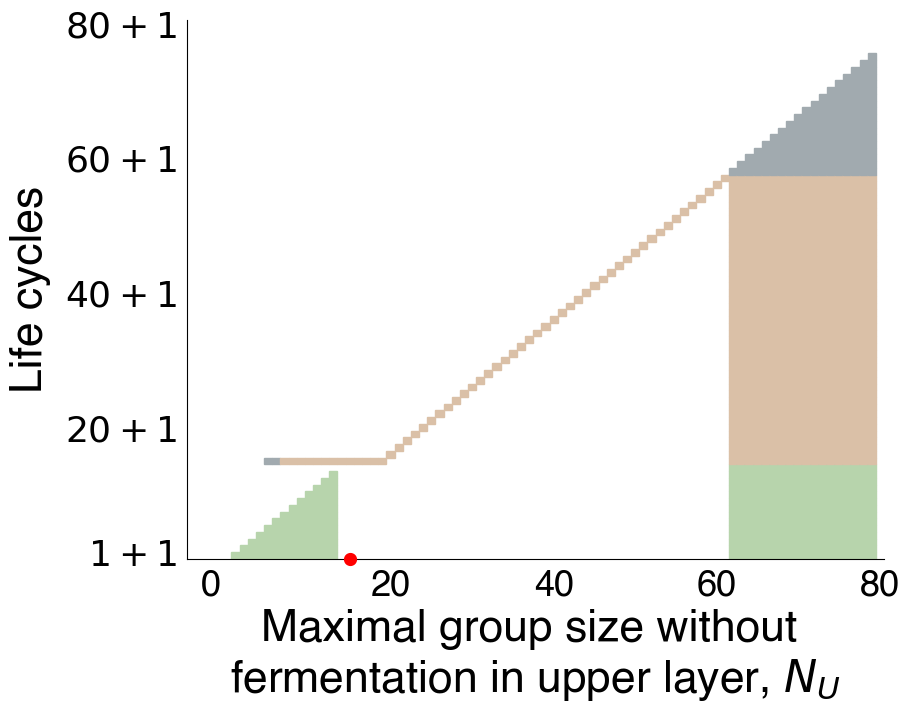

rF=1


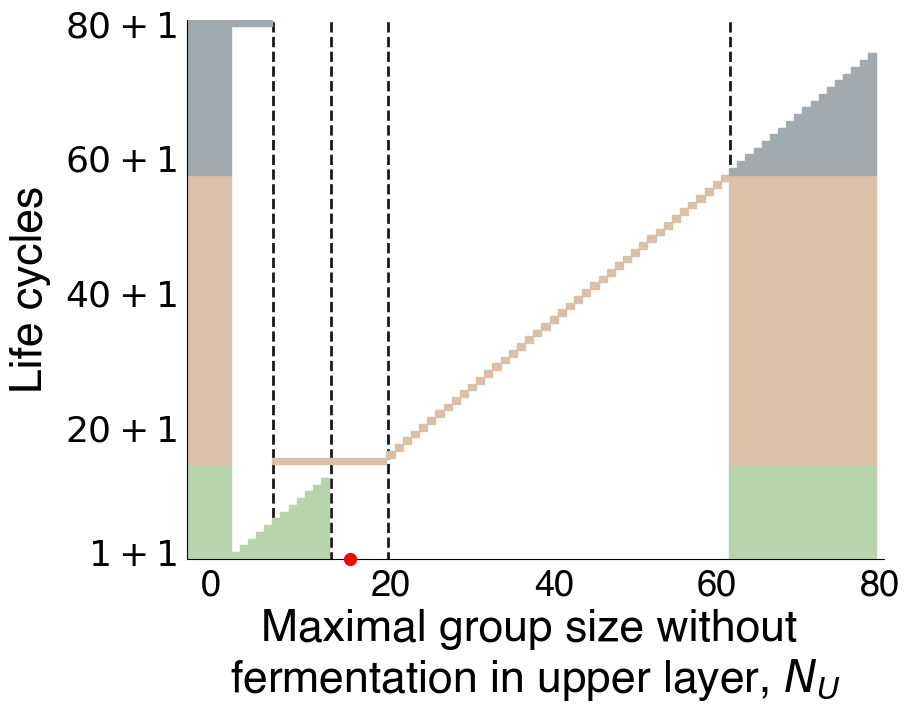

rF=3


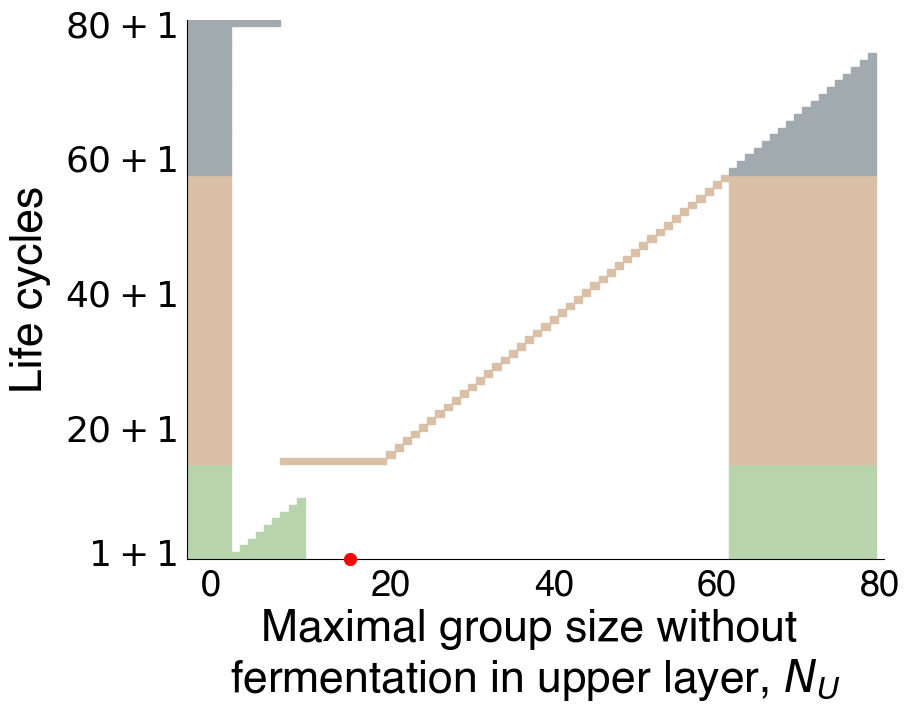

rF=5


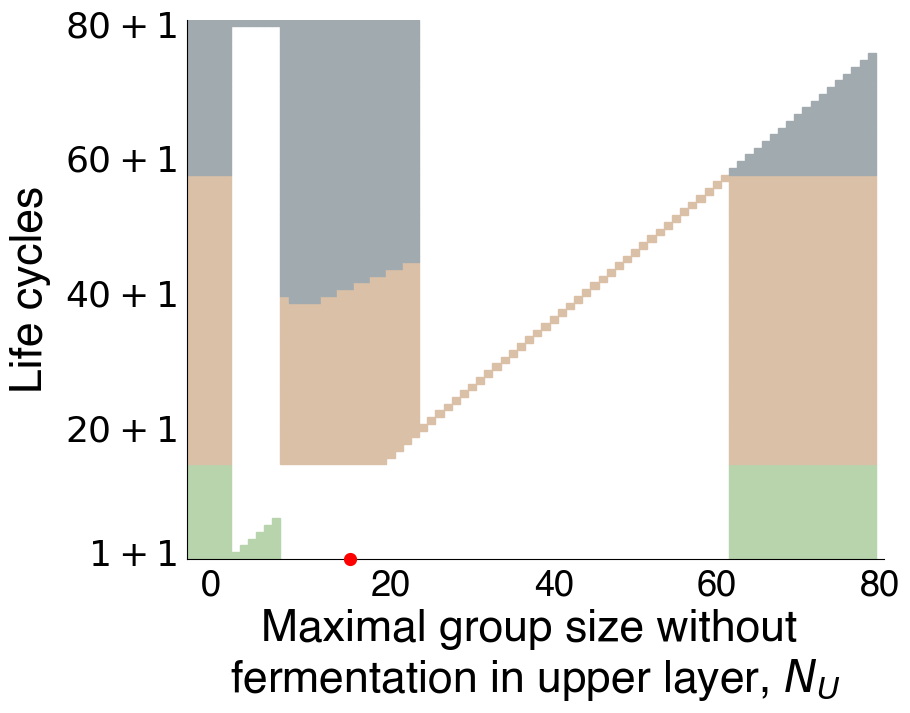

rF=6


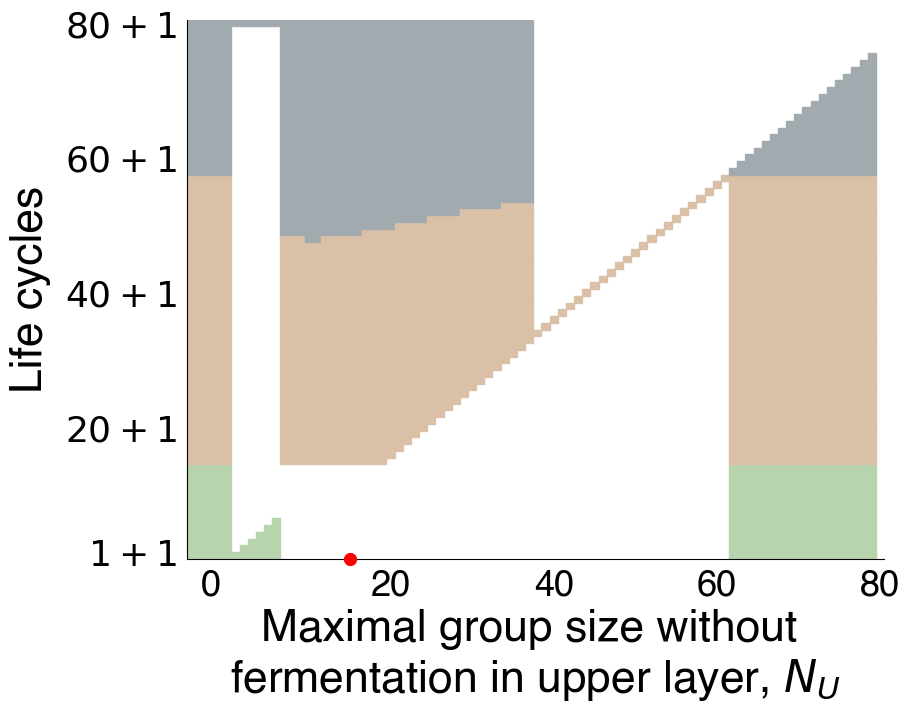

In [13]:
## Plotting for each rF scenario

for rF in [0,1,3,5,6]:
    print("rF="+str(rF))
    df=pd.read_csv("Data/Data_Cell_np1/Cell_results_Np1_"+str(rF)+".csv",header=None)
    M_l=[]
    for i in range(80):
        x=df.T[i].to_numpy()
        M_l.append(x[~np.isnan(x)])


    fig, ax = pl.subplots(figsize=(9, 7))

    hfont = {'fontname':'Helvetica'}
    if rF==1:
        ax.plot([5.65,5.65],[0,86.5],lw=2,c='k',alpha=0.9,ls='--',zorder=0)
        ax.plot([12.65,12.65],[0,86.5],lw=2,c='k',alpha=0.9,ls='--',zorder=0)
        ax.plot([19.65,19.65],[0,86.5],lw=2,c='k',alpha=0.9,ls='--',zorder=0)
        ax.plot([61.65,61.65],[0,86.5],lw=2,c='k',alpha=0.9,ls='--',zorder=0)

    ax.scatter([15],[0.5],lw=4,c='r',alpha=1,zorder=10,clip_on=False, s=30)

    for i in range(len(M_l)):
        df=pd.read_csv("Data/Data_Cell_np1/Cells_K_"+str(i)+"_"+str(rF)+".csv")
        K_up=df["K_A"].to_numpy()
        K_low=df["K_B"].to_numpy()
        for j in M_l[i]:
            if j<15: # Small life cycle
                if i==0:
                    ax.fill([i-5,i-5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#b7d4acff')
                else:
                    ax.fill([i-0.5,i-0.5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#b7d4acff')
            elif K_up[int(j)]>K_low[int(j)]: # Intermediate life cycle
                if i==0:
                    ax.fill([i-5,i-5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#dac0a7ff')
                else:
                    ax.fill([i-0.5,i-0.5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#dac0a7ff')
            elif K_up[int(j)]<=K_low[int(j)]: # Large life cycle
                if i==0:
                    ax.fill([i-5,i-5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#a1aaafff')
                else:
                    ax.fill([i-0.5,i-0.5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#a1aaafff')


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-5,80.5)
    ax.set_ylim(0.5,80.5)

    ax.set_xticks([-2,20,40,60,80])
    ax.set_yticks([1.5,20,40,60,80])

    ax.set_xticklabels([0,20,40,60,80])
    ax.set_yticklabels([r'$1+1$',r'$20+1$',r'$40+1$',r'$60+1$',r'$80+1$'])

    pl.tick_params(left = False)
    pl.tick_params(bottom = False)
    ax.tick_params(labelsize=26)

    for tick in ax.get_xticklabels():
        tick.set_fontname("Helvetica")
    for tick in ax.get_yticklabels():
        tick.set_fontname("Helvetica")

    ax.set_ylabel('Life cycles',fontsize=32,rotation=90,labelpad=10,multialignment='center',**hfont)
    ax.set_xlabel('Maximal group size without \nfermentation in upper layer, $N_U$',fontsize=32,multialignment='center',**hfont)

    pl.show()


    fig.savefig(r"Figures/Np1_"+str(rF)+".png",bbox_inches='tight')
    fig.savefig(r"Figures/Np1_"+str(rF)+".pdf",bbox_inches='tight')
    fig.savefig(r"Figures/Np1_"+str(rF)+".svg",bbox_inches='tight')

# Figure S2a #

In [ ]:
## Packages and functions


from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as pl
from numpy import random
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import fsolve

def Nt1_simulation(t,u,r,pA,pB,g,NS,l,Life_cycles):
    #u = variable list
    #du = du/dt  
    du=np.zeros(len(u))

    #t = time
    #l[i] = number of cells in the group represented by u[i]
    #Life_cycles = list of the present life cycles in the system
    # if Life_cycles=[i,j,w], that means that life cycles i+1, j+1 and w+1 are present

    #r,pA,pB,g,NS = parameters
    
    K_up=0 #Number of cells in the upper layer
    K_low=0 #Number of cells in the lower layer

    for i_K in range(len(u)):
        if pA[l[i_K]]==1:
            K_up += l[i_K]*u[i_K]
        else:
            K_low += l[i_K]*u[i_K]

    
    w=0 #Life cycle index
    ww=0 #Group size index
    
    
    while w<len(Life_cycles): 
        
        Nn=Life_cycles[w]
        
        #If the life cycle is 1+1 (unicellular)
        if Nn==1:
            du[ww] = r[1]*u[ww] - u[ww]*g*K_up

        #For every other life cycle:
        else:

            if Nn<NS: #If the life cycle is small:
 
                du[ww] = -r[1]*u[ww] - u[ww]*g*K_up + (Nn+1)*Nn*r[Nn]*u[ww+Nn-1] #Single cell life stage i=1
                
                for i in range(1,Nn):#Group life stages 
                    du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_up)*u[ww+i] 


            else: #If the life cycle is intermediate or large:
                du[ww] = -r[1]*u[ww] - u[ww]*g*K_up + (Nn+1)*Nn*r[Nn]*u[ww+Nn-1] #Single cell life stage i=1
                
                for i in range(1,NS-1):#Group life stages in the upper layer
                    du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_up)*u[ww+i] 

                for i in range(NS-1,Nn):#Group life stages in the lower layer
                    du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_low)*u[ww+i] 


        #Next life cycle starting at index ww       
        w+=1 
        ww+=Nn 

    return du


def R0_calculation(u_eq,r,pA,pB,g,l,NS,NE):

    #u_eq= variable list in the stationary state

    K_up=0 #Number of cells in the upper layer
    K_low=0 #Number of cells in the lower layer
    for i_K in range(len(u_eq)):
        if pA[l[i_K]]==1:
            K_up += l[i_K]*u_eq[i_K]
        else:
            K_low += l[i_K]*u_eq[i_K]

    C_l=[0] #competition experienced by a group of size "i". There are no groups of size 0, then C_l[0]=0
    for i_C in np.arange(NE)+1:
        if pA[i_C]==1:
            C_l.append(g*K_up)
        else:
            C_l.append(g*K_low)

    R0=[0,2*r[1]/(r[1]+C_l[1])] #R0[i]= R0 of a i+1 life cycle. 0+1 does not exist, then R0[0]= 0. R0[1]= 2*r[1]/(r[1]+Cl[1]).

    if K_low==0 and r[NS]==0: #If there are no groups in the lower layer, the basic reproduction number for n>NS goes to infinity as long as r>0.
          #Since we only care whether R0>1 or R0<1, we set R0[i>=NS]=2
        for N in range(2,NS):
            R0_n=R0[N-1]*(N+1)*r[N]/(N*r[N] + C_l[N])
            R0.append(R0_n)
        for n in range(NS,NE+1):
            R0.append(0)

    else:
        for N in range(2,NE+1):
            R0_n=R0[N-1]*(N+1)*r[N]/(N*r[N] + C_l[N])
            R0.append(R0_n)

    return R0

def Mutations(NE,R0,Life_cycles,err):

    #err = 10^-10 = small window for numerical error

    #Create a list of possible invaders based: being able to invade (R0[i]>=1), and not being currently present in the system (i is not in Life_cycles). 
    Possible_invaders=[]
    for i in range(1,NE+1):
        if R0[i]>1-err and (i not in Life_cycles):
            Possible_invaders.append(i)
    if len(Possible_invaders)==1:
        i_mut=0
    else:
        i_mut=random.randint(0, len(Possible_invaders)-1)
        
    return Possible_invaders[i_mut] #Sample one life cycle randomly from the list of potential invaders

In [ ]:
# Eco-evolutionary algorithm

for NU in np.arange(0,81): 
    print(NU)
   ##Parameters:
    #NU=7
    #idx=0
    DeltaN=4
    NL= NU-DeltaN
    rO=6.8
    rF=1
    NS=10
    g=1#gamma
    #Maximal group size in the simulations=100
    NE=100


    ##Spatial dirtribution:
    #pA[i] = proportion of groups of size "i" in environment A (i.e., the upper layer)
    pA=np.zeros(NE+1)
    for i in range(1,NS):
        pA[i]=1
    for i in range(NS,NE+1):
        pA[i]=0
    #pB[i] = 1 - pA[i] = proportion of groups of size "i" in environment B (i.e., the lower layer)
    pB=1-pA
    # We do not consider groups of size 0: pA[0]=pB[0]=0 


    ##Growth rates:

    #If NU<DeltaN => No oxygen in the lower layer
    if NL<0:
        DeltaN=NU
        NL=0

    #Creating the growth rate arrays
    rA=np.zeros(NE+1) #rA[i]= Growth rate of a cell in a group of size "i" in environment A (i.e., the upper layer)
    rB=np.zeros(NE+1) #rB[i]= Growth rate of a cell in a group of size "i" in environment B (i.e., the lower layer)
    r=np.zeros(NE+1) #r[i]= Average growth rate (across both environments) of a cell in a group of size "i"
    # We do not consider groups of size 0: rA[0]=rB[0]=r[0]=0 

    #Assigning values to the growth rate arrays
    for i in range(1,NE+1):
        if i<=NU:
            rA[i]= rO
        else:
            rA[i]=(rO*NU + rF*(i-NU))/i

        if i<=NL:
            rB[i]= rO
        else:
            rB[i]=(rO*(NL) + rF*(i-NL))/i

        r[i]= rA[i]*pA[i] + rB[i]*pB[i]





    err= 10**(-8) #err = 10^-8 = small window for numerical error
    # R0>1-err corresponds to R0>=1,
    # R0>1+err corresponds to R0>1.

    N_tries=1
    for idx_tries in range(N_tries):
        #The initial community cosnsists of a resident 1+1 life cycle. 
        Life_cycles=[1]
        l=[1]

        #Initial condition
        u0 = np.zeros(1)
        u0[0]=(r[1])/g #Equilibrium abundance of 1+1 in isolation
        u_eq=u0
        R0=R0_calculation(u_eq,r,pA,pB,g,l,NS,NE)
    
        R0_max="Invader"
        while R0_max=="Invader":
            ##Introduce a new mutant life cycle M_N
            M_N=Mutations(NE,R0,Life_cycles,err) 
            #print(M_N)
            Life_cycles.append(M_N) #Append life 

            
            ##Initial conditions:
            #u0[i] = initial condition for variable i 
            #u_eq[i] = equilibrium value of variable i found in the previous iteration
            #u_eq_num[i] = equilibrium value of the number of cells belonging to life cycle i+1 found in the previous iteration 
            u0 = np.zeros(len(u_eq)+M_N)
            for i in range(len(u_eq)): #q0 = equilibrium state found on the previous iteration (u_eq) + small abundance of mutant single cells.
                u0[i]=u_eq[i]
            u0[len(u_eq)]=sum(l*u_eq)*0.01 #The introduces abundance of mutants correspond to 1% of the resident cell population.


            ##Useful lists:
            #lc= Max Size of each life cycle strategy
            lc=[]
            for n in Life_cycles:
                for i in range(1,n+1):
                    lc.append(n)
            lc=np.array(lc)
            #l = Size of each life cycle strategy
            l=[]
            for n in Life_cycles:
                for i in range(1,n+1):
                    l.append(i)
            l=np.array(l)

            
            ##Numerical integration of the dynamics until reaching equilibrium
            ts0=np.linspace(1,50000000,1000) #Define time interval
            usol = solve_ivp(Nt1_simulation,(ts0[0],ts0[-1]),u0,args=(r,pA,pB,g,NS,l,Life_cycles), dense_output=True,method='LSODA')
            u_t= usol.sol(ts0)#time series
            u_eq=u_t[:,-1]
        
            ##Calculate R0
            R0=R0_calculation(u_eq,r,pA,pB,g,l,NS,NE)


            ##Drop life cycles that were competitively excluded (i.e., if N+1 is in Life_cycles and R0[N]<0):
            Life_cycles_new=[] #Life_cycle list after dropping the excluded life cycles
            u_eq_new=[] #u_eq list after dropping the excluded life cycles
            for i in range(len(Life_cycles)):
                i_lc=Life_cycles[i]
                if R0[i_lc]>=1-err:
                    Life_cycles_new.append(i_lc)
                    i_pos=list(lc).index(i_lc)
                    for j in range(i_pos,i_pos+i_lc):
                        u_eq_new.append(u_eq[j])


            Life_cycles=Life_cycles_new
            u_eq=np.array(u_eq_new)

            ##Useful lists:
            #lc= Max Size of each life cycle strategy
            lc=[]
            for n in Life_cycles:
                for i in range(1,n+1):
                    lc.append(n)
            lc=np.array(lc)
            #l = Size of each life cycle strategy
            l=[]
            for n in Life_cycles:
                for i in range(1,n+1):
                    l.append(i)
            l=np.array(l)
            

            ##Check if this equilibrium can disrupted by an invader (i.e., R0>1 for any i that is not in the Life_cycles list).
            #If such life cycles cannot be found, we have reacxhed an Evolutionarily Stable Community (ESC);
            # then R0_max="No invader" and the "while-loop" is complete. 
            R0_max="No Invader"
            for i in range(1,NE+1):
                if R0[i]>1+err:
                    R0_max="Invader" #If any non-resident can invade, R0_max="Invader" and the loop continues
            #Note that, for the purpose of completing this eco-evo algorithm, we are only concerned with life cycles that can invade 
            # non-neutrally (i.e. R0>1 rather than R0>=1). 
            #Neutral invaders (R0=1) can invade but will remain in small abundances, since our model does not acoount for stochasticity.



    ##After the ESC is reached, compute all life cycles that can coexist in it (including neutral coexistence, i.e., R0=1).
        ESC=[]
        for i in range(1,NE+1):
            if R0[i]>1-err:
                ESC.append(i)
        print(ESC)
        df=pd.DataFrame(ESC)
        df.to_csv("Data/Data_Cell_nt1/Cells_"+str(NU)+"_"+str(idx_tries)+"_"+str(rF)+".csv",index=False,header=False)
        

In [ ]:
# Joining results 

Results=[]
Type="Cells"
for NU in range(0,81):
    N_tries=1

    for tries in range(N_tries):
        df=pd.read_csv("Data/Data_Cell_nt1/Cells_"+str(NU)+"_"+str(tries)+"_"+str(rF)+".csv",header=None)
        df_n=df.to_numpy()

        df_l=[]
        for i in range(len(df_n)):
            df_l.append(df_n[i][0])
        df_l.sort()

    Results.append(df_l)

In [ ]:
# Computing the number of cells on the upper and lower layer for a life cycle in isolation.
# This analysis is used to classify whether a life cycle is small, intermediate or large.

for NU in np.arange(0,81): 
   ##Parameters:
    DeltaN=4
    NL= NU-DeltaN
    rO=6.8
    rF=1
    NS=10
    g=1#gamma
    #Maximal group size in the simulations=80
    NE=100


    ##Spatial dirtribution:
    #pA[i] = proportion of groups of size "i" in environment A (i.e., the upper layer)
    pA=np.zeros(NE+1)
    for i in range(1,NS):
        pA[i]=1
    for i in range(NS,NE+1):
        pA[i]=0
    #pB[i] = 1 - pA[i] = proportion of groups of size "i" in environment B (i.e., the lower layer)
    pB=1-pA
    # We do not consider groups of size 0: pA[0]=pB[0]=0 


    ##Growth rates:

    #If NU<DeltaN => No oxygen in the lower layer
    if NL<0:
        DeltaN=NU
        NL=0

    #Creating the growth rate arrays
    rA=np.zeros(NE+1) #rA[i]= Growth rate of a cell in a group of size "i" in environment A (i.e., the upper layer)
    rB=np.zeros(NE+1) #rB[i]= Growth rate of a cell in a group of size "i" in environment B (i.e., the lower layer)
    r=np.zeros(NE+1) #r[i]= Average growth rate (across both environments) of a cell in a group of size "i"
    # We do not consider groups of size 0: rA[0]=rB[0]=r[0]=0 

    #Assigning values to the growth rate arrays
    for i in range(1,NE+1):
        if i<=NU:
            rA[i]= rO
        else:
            rA[i]=(rO*NU + rF*(i-NU))/i

        if i<=NL:
            rB[i]= rO
        else:
            rB[i]=(rO*(NL) + rF*(i-NL))/i

        r[i]= rA[i]*pA[i] + rB[i]*pB[i]

    K_A=[0]
    K_B=[0]

    for N_n in np.arange(1,81):
        ##Initial conditions:
        #u0[i] = initial condition for variable i 
        #Initial condition
        Life_cycles=[N_n]
        u0 = np.zeros(N_n)
        u0[0]=0.1*(r[1])/g #Equilibrium abundance of 1+1 in isolation

        ##Useful lists:
        #lc= Max Size of each life cycle strategy
        lc=[]
        for n in Life_cycles:
            for i in range(1,n+1):
                lc.append(n)
        lc=np.array(lc)
        #l = Size of each life cycle strategy
        l=[]
        for n in Life_cycles:
            for i in range(1,n+1):
                l.append(i)
        l=np.array(l)

        
        ##Numerical integration of the dynamics until reaching equilibrium
        ts0=np.linspace(1,50000000,1000) #Define time interval
        usol = solve_ivp(Nt1_simulation,(ts0[0],ts0[-1]),u0,args=(r,pA,pB,g,NS,l,Life_cycles), dense_output=True,method='LSODA')
        u_t= usol.sol(ts0)#time series
        u_eq=u_t[:,-1]

        K_up=0 #Number of cells in the upper layer
        K_low=0 #Number of cells in the lower layer
        for i_K in range(len(u_eq)):
            if pA[l[i_K]]==1:
                K_up += l[i_K]*u_eq[i_K]
            else:
                K_low += l[i_K]*u_eq[i_K]

        K_A.append(K_up)
        K_B.append(K_low)
    
    df=pd.DataFrame({"K_A":K_A,"K_B":K_B})
    df.to_csv("Data/Data_Cell_nt1/Cells_K_"+str(NU)+"_"+str(rF)+".csv",index=False)
        

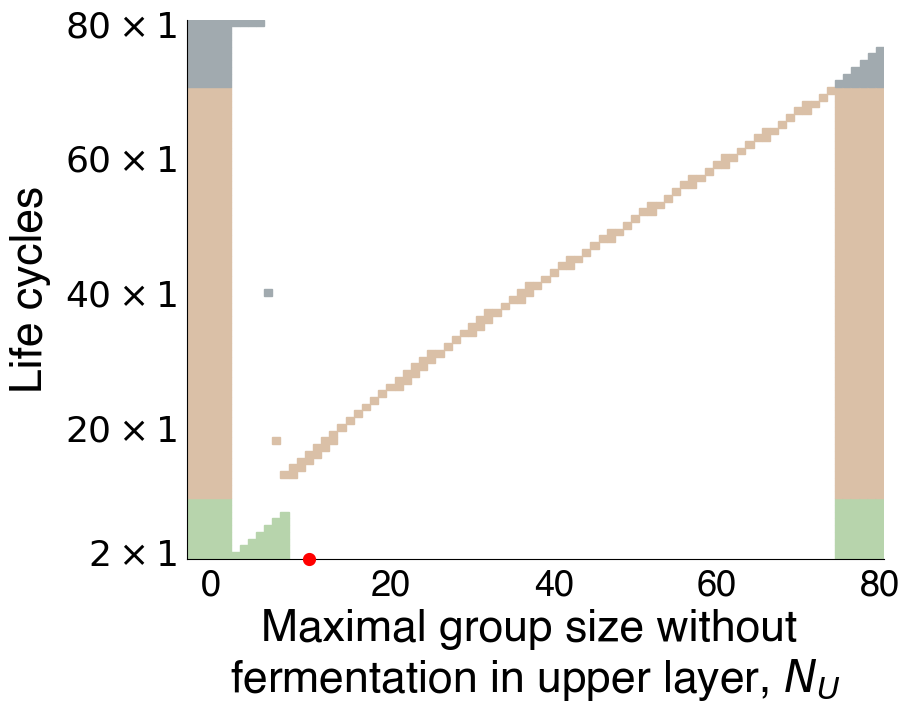

In [9]:
# Plotting

df=pd.read_csv("Data/Data_Cell_nt1/Cell_results_Nt1.csv",header=None)
rF=1
M_l=[]
for i in range(81):
    x=df.T[i].to_numpy()
    x[x==100]=-1
    x[x>=80]=np.nan
    x[x==-1]=80
    M_l.append(x[~np.isnan(x)])


fig, ax = pl.subplots(figsize=(9, 7))

hfont = {'fontname':'Helvetica'}




for i in range(len(M_l)):
    df=pd.read_csv("Data/Data_Cell_nt1/Cells_K_"+str(i)+"_"+str(rF)+".csv")
    K_up=df["K_A"].to_numpy()
    K_low=df["K_B"].to_numpy()
    for j in M_l[i]:
        if j<10: # Small life cycle
            if i==0:
                ax.fill([i-5,i-5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#b7d4acff')
            else:
                ax.fill([i-0.5,i-0.5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#b7d4acff')
        elif K_up[int(j)]>K_low[int(j)]: # Intermediate life cycle
            if i==0:
                ax.fill([i-5,i-5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#dac0a7ff')
            else:
                ax.fill([i-0.5,i-0.5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#dac0a7ff')
        elif K_up[int(j)]<=K_low[int(j)]: # Large life cycle
            if i==0:
                ax.fill([i-5,i-5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#a1aaafff')
            else:
                ax.fill([i-0.5,i-0.5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#a1aaafff')


ax.scatter([10],[0.5],lw=4,c='r',alpha=1,zorder=10,clip_on=False, s=30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(-5,80.5)
ax.set_ylim(0.5,80.5)

ax.set_xticks([-2,20,40,60,80])
ax.set_yticks([1.5,20,40,60,80])

ax.set_xticklabels([0,20,40,60,80])
ax.set_yticklabels([r'$2\times 1$',r'$20\times 1$',r'$40\times 1$',r'$60\times 1$',r'$80\times 1$'])

#pl.text(-14, 80.5, r'$(N \to \infty)$', fontsize=20)


pl.tick_params(left = False)
pl.tick_params(bottom = False)
ax.tick_params(labelsize=26)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")

ax.set_ylabel('Life cycles',fontsize=32,rotation=90,labelpad=10,multialignment='center',**hfont)
ax.set_xlabel('Maximal group size without \nfermentation in upper layer, $N_U$',fontsize=32,multialignment='center',**hfont)

pl.show()


fig.savefig(r"Figures/Nt1.png",bbox_inches='tight')
fig.savefig(r"Figures/Nt1.svg",bbox_inches='tight')
fig.savefig(r"Figures/Nt1.pdf",bbox_inches='tight')

# Figure S2b #

In [ ]:
# Packages and Functions

from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as pl
from numpy import random
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import fsolve
import os
#idx = int(os.environ["SLURM_ARRAY_TASK_ID"])

def N2N2_simulation(t,u,r,pA,pB,g,NS,l,Life_cycles):
    #u = variable list
    #du = du/dt  
    du=np.zeros(len(u))

    #t = time
    #l[i] = number of cells in the group represented by u[i]
    #Life_cycles = list of the present life cycles in the system
    # if Life_cycles=[i,j,w], that means that life cycles i+1, j+1 and w+1 are present

    #r,pA,pB,g,NS = parameters
    
    K_up=0 #Number of cells in the upper layer
    K_low=0 #Number of cells in the lower layer

    for i_K in range(len(u)):
        if pA[l[i_K]]==1:
            K_up += l[i_K]*u[i_K]
        else:
            K_low += l[i_K]*u[i_K]


    
    w=0 #Life cycle index
    ww=0 #Group size index
    



    while w<len(Life_cycles): 
            Nn=Life_cycles[w]
            
            if Nn==1:
                du[ww] = r[1]*u[ww] - g*u[ww]*K_up
                
            elif Nn==2 and NS>2:
                du[ww] = -r[1]*u[ww] - g*u[ww]*K_up + Nn*r[Nn]*u[ww+1]
                
                du[ww+1] =r[1]*u[ww] -g*K_up*u[ww+1]
            elif Nn==2 and NS==2:
                du[ww] = -r[1]*u[ww] - g*u[ww]*K_up + Nn*r[Nn]*u[ww+1]
                
                du[ww+1] =r[1]*u[ww] -g*K_low*u[ww+1]

            elif Nn<NS: #If the life cycle is small:    
                if (Nn+1)%2==0:
                    
                    du[ww] = -r[1]*u[ww] - g*u[ww]*K_up  

                    for i in range(1,Nn):
                        if i==((Nn+1)//2) -1:
                            du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_up)*u[ww+i]  + 2*Nn*r[Nn]*u[ww+Nn-1] 
                        
                        else:
                            du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_up)*u[ww+i] 
                        
                        
                elif (Nn+1)%2!=0:
                    
                    du[ww] = -r[1]*u[ww] - g*u[ww]*K_up 

                    for i in range(1,Nn):
                        if i==((Nn+1)//2) - 1 or i==(Nn+1)//2 :
                            du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_up)*u[ww+i]+ Nn*r[Nn]*u[ww+Nn-1] 
                        else:
                            du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_up)*u[ww+i] 
            
            else: #If the life cycle is intermediate or large:
                if (Nn+1)%2==0:
                    
                    du[ww] = -r[1]*u[ww] - g*u[ww]*K_up  

                    for i in range(1,NS-1):
                        if i==((Nn+1)//2) -1:
                            du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_up)*u[ww+i]  + 2*Nn*r[Nn]*u[ww+Nn-1] 
                        else:
                            du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_up)*u[ww+i] 

                    for i in range(NS-1,Nn):
                        if i==((Nn+1)//2) -1:
                            du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_low)*u[ww+i]  + 2*Nn*r[Nn]*u[ww+Nn-1] 
                        else:
                            du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_low)*u[ww+i] 
                        
            
                elif (Nn+1)%2!=0:
                    
                    du[ww] = -r[1]*u[ww] - g*u[ww]*K_up 

                    for i in range(1,NS-1):
                        if i==((Nn+1)//2)-1 or i==(Nn+1)//2 :
                            du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_up)*u[ww+i]+ Nn*r[Nn]*u[ww+Nn-1] 
                            
                        else:
                            du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_up)*u[ww+i] 

                    for i in range(NS-1,Nn):
                        if i==((Nn+1)//2)-1 or i==(Nn+1)//2 :
                            du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_low)*u[ww+i]+ Nn*r[Nn]*u[ww+Nn-1] 
                            
                        else:
                            du[ww+i] =i*r[i]*u[ww+i-1] -((i+1)*r[i+1]+g*K_low)*u[ww+i] 

            w+=1
            ww+=Nn  
    return du



def R0_calculation(u_eq,r,pA,pB,g,l,NS,NE):

    #u_eq= variable list in the stationary state

    K_up=0 #Number of cells in the upper layer
    K_low=0 #Number of cells in the lower layer
    for i_K in range(len(u_eq)):
        if pA[l[i_K]]==1:
            K_up += l[i_K]*u_eq[i_K]
        else:
            K_low += l[i_K]*u_eq[i_K]

    C_l=[0] #competition experienced by a group of size "i". There are no groups of size 0, then C_l[0]=0
    for i_C in np.arange(NE)+1:
        if pA[i_C]==1:
            C_l.append(g*K_up)
        else:
            C_l.append(g*K_low)

    R0=[0,2*r[1]/(r[1]+C_l[1])] #R0[i]= R0 of a i+1 life cycle. 0+1 does not exist, then R0[0]= 0. R0[1]= 2*r[1]/(r[1]+Cl[1]).

    


    if K_low==0 and r[NS]==0: #If there are no groups in the lower layer, the basic reproduction number for n>NS goes to infinity as long as r>0.
          #Since we only care whether R0>1 or R0<1, we set R0[i>=NS]=2
        for N in range(2,NS):
            if (N+1)%2==0:
                R0_n=2
                for j in range((N+1)//2,N+1):
                    R0_n=R0_n*(j*r[j]/(j*r[j]+ g*C_l[j]))
                R0.append(R0_n)
            elif (N+1)%2!=0:
                R0_n=(1+ ((N+1)//2)*r[(N+1)//2]/(((N+1)//2)*r[(N+1)//2] + g*C_l[(N+1)//2]))
                for j in range((N+1)//2+1,N+1):
                    R0_n=R0_n*(j*r[j]/(j*r[j] + g*C_l[j]))
                R0.append(R0_n)  
                
        for n in range(NS,NE+1):
            R0.append(0)

    else:
        for N in range(2,NE+1):
            if (N+1)%2==0:
                R0_n=2
                for j in range((N+1)//2,N+1):
                    R0_n=R0_n*(j*r[j]/(j*r[j]+ g*C_l[j]))
                R0.append(R0_n)
            elif (N+1)%2!=0:
                R0_n=(1+ ((N+1)//2)*r[(N+1)//2]/(((N+1)//2)*r[(N+1)//2] + g*C_l[(N+1)//2]))
                for j in range((N+1)//2+1,N+1):
                    R0_n=R0_n*(j*r[j]/(j*r[j] + g*C_l[j]))
                R0.append(R0_n)  

    return R0

def Mutations(NE,R0,Life_cycles,err):

    #err = 10^-10 = small window for numerical error

    #Create a list of possible invaders based: being able to invade (R0[i]>=1), and not being currently present in the system (i is not in Life_cycles). 
    Possible_invaders=[]
    for i in range(1,NE+1):
        if R0[i]>1-err and (i not in Life_cycles):
            Possible_invaders.append(i)
    #print("Possible_invaders")
    #print(Possible_invaders)
    if len(Possible_invaders)==1:
        i_mut=0
    else:
        i_mut=random.randint(0, len(Possible_invaders)-1)
        
    return Possible_invaders[i_mut] #Sample one life cycle randomly from the list of potential invaders

In [ ]:
# Eco-evolutionary algorithm

for NU in np.arange(0,81): 
   ##Parameters:
    DeltaN=4
    NL= NU-DeltaN
    rO=6.8
    rF=1
    NS=15
    g=1#gamma
    #Maximal group size in the simulations=100
    NE=100


    ##Spatial dirtribution:
    #pA[i] = proportion of groups of size "i" in environment A (i.e., the upper layer)
    pA=np.zeros(NE+1)
    for i in range(1,NS):
        pA[i]=1
    for i in range(NS,NE+1):
        pA[i]=0
    #pB[i] = 1 - pA[i] = proportion of groups of size "i" in environment B (i.e., the lower layer)
    pB=1-pA
    # We do not consider groups of size 0: pA[0]=pB[0]=0 


    ##Growth rates:

    #If NU<DeltaN => No oxygen in the lower layer
    if NL<0:
        DeltaN=NU
        NL=0

    #Creating the growth rate arrays
    rA=np.zeros(NE+1) #rA[i]= Growth rate of a cell in a group of size "i" in environment A (i.e., the upper layer)
    rB=np.zeros(NE+1) #rB[i]= Growth rate of a cell in a group of size "i" in environment B (i.e., the lower layer)
    r=np.zeros(NE+1) #r[i]= Average growth rate (across both environments) of a cell in a group of size "i"
    # We do not consider groups of size 0: rA[0]=rB[0]=r[0]=0 

    #Assigning values to the growth rate arrays
    for i in range(1,NE+1):
        if i<=NU:
            rA[i]= rO
        else:
            rA[i]=(rO*NU + rF*(i-NU))/i

        if i<=NL:
            rB[i]= rO
        else:
            rB[i]=(rO*(NL) + rF*(i-NL))/i

        r[i]= rA[i]*pA[i] + rB[i]*pB[i]





    err= 10**(-8) #err = 10^-8 = small window for numerical error
    # R0>1-err corresponds to R0>=1,
    # R0>1+err corresponds to R0>1.

    N_tries=1
    for idx_tries in range(N_tries):
        #The initial community cosnsists of a resident 1+1 life cycle. 
        Life_cycles=[1]
        l=[1]

        #Initial condition
        u0 = np.zeros(1)
        u0[0]=(r[1])/g #Equilibrium abundance of 1+1 in isolation
        u_eq=u0
        R0=R0_calculation(u_eq,r,pA,pB,g,l,NS,NE)
    
        R0_max="Invader"
        while R0_max=="Invader":
            ##Introduce a new mutant life cycle M_N
            M_N=Mutations(NE,R0,Life_cycles,err) 
            #print(M_N)
            Life_cycles.append(M_N) #Append life 
            
            ##Initial conditions:
            #u0[i] = initial condition for variable i 
            #u_eq[i] = equilibrium value of variable i found in the previous iteration
            #u_eq_num[i] = equilibrium value of the number of cells belonging to life cycle i+1 found in the previous iteration 
            u0 = np.zeros(len(u_eq)+M_N)
            for i in range(len(u_eq)): #q0 = equilibrium state found on the previous iteration (u_eq) + small abundance of mutant single cells.
                u0[i]=u_eq[i]
            u0[len(u_eq)]=sum(l*u_eq)*0.01 #The introduces abundance of mutants correspond to 1% of the resident cell population.


            ##Useful lists:
            #lc= Max Size of each life cycle strategy
            lc=[]
            for n in Life_cycles:
                for i in range(1,n+1):
                    lc.append(n)
            lc=np.array(lc)
            #l = Size of each life cycle strategy
            l=[]
            for n in Life_cycles:
                for i in range(1,n+1):
                    l.append(i)
            l=np.array(l)

            
            ##Numerical integration of the dynamics until reaching equilibrium
            ts0=np.linspace(1,500000000000,1000) #Define time interval
            usol = solve_ivp(N2N2_simulation,(ts0[0],ts0[-1]),u0,args=(r,pA,pB,g,NS,l,Life_cycles), dense_output=True,method='LSODA')
            u_t= usol.sol(ts0)#time series
            u_eq=u_t[:,-1]
        
            ##Calculate R0
            R0=R0_calculation(u_eq,r,pA,pB,g,l,NS,NE)

    
            ##Drop life cycles that were competitively excluded (i.e., if N+1 is in Life_cycles and R0[N]<0):
            Life_cycles_new=[] #Life_cycle list after dropping the excluded life cycles
            u_eq_new=[] #u_eq list after dropping the excluded life cycles
            for i in range(len(Life_cycles)):
                i_lc=Life_cycles[i]
                if R0[i_lc]>=1-err:
                    Life_cycles_new.append(i_lc)
                    i_pos=list(lc).index(i_lc)
                    for j in range(i_pos,i_pos+i_lc):
                        u_eq_new.append(u_eq[j])
            #Update lists
            
            Life_cycles=Life_cycles_new
            u_eq=np.array(u_eq_new)

            ##Useful lists:
            #lc= Max Size of each life cycle strategy
            lc=[]
            for n in Life_cycles:
                for i in range(1,n+1):
                    lc.append(n)
            lc=np.array(lc)
            #l = Size of each life cycle strategy
            l=[]
            for n in Life_cycles:
                for i in range(1,n+1):
                    l.append(i)
            l=np.array(l)
            

            ##Check if this equilibrium can disrupted by an invader (i.e., R0>1 for any i that is not in the Life_cycles list).
            #If such life cycles cannot be found, we have reacxhed an Evolutionarily Stable Community (ESC);
            # then R0_max="No invader" and the "while-loop" is complete. 
            R0_max="No Invader"
            for i in range(1,NE+1):
                if R0[i]>1+err:
                    R0_max="Invader" #If any non-resident can invade, R0_max="Invader" and the loop continues
            #Note that, for the purpose of completing this eco-evo algorithm, we are only concerned with life cycles that can invade 
            # non-neutrally (i.e. R0>1 rather than R0>=1). 
            #Neutral invaders (R0=1) can invade but will remain in small abundances, since our model does not acoount for stochasticity.



    ##After the ESC is reached, compute all life cycles that can coexist in it (including neutral coexistence, i.e., R0=1).
        ESC=[]
        for i in range(1,NE+1):
            if R0[i]>1-err:
                ESC.append(i)
        print(ESC)
        df=pd.DataFrame(ESC)
        df.to_csv("Data/Data_Cell_n2n2/Cells_"+str(NU)+"_"+str(idx_tries)+"_"+str(rF)+".csv",index=False,header=False)
        

In [ ]:
# Joining results

Results=[]
Type="Cells"
for NU in range(0,81):
    N_tries=1

    for tries in range(N_tries):
        df=pd.read_csv("Data/Data_Cell_n2n2/Cells_"+str(NU)+"_"+str(tries)+"_"+str(rF)+".csv",header=None)
        df_n=df.to_numpy()

        df_l=[]
        for i in range(len(df_n)):
            df_l.append(df_n[i][0])
        df_l.sort()

    Results.append(df_l)

In [ ]:
# Computing the number of cells on the upper and lower layer for a life cycle in isolation.
# This analysis is used to classify whether a life cycle is small, intermediate or large.

for NU in np.arange(0,81): 
   ##Parameters:
    DeltaN=4
    NL= NU-DeltaN
    rO=6.8
    rF=1
    NS=15
    g=1#gamma
    #Maximal group size in the simulations=100
    NE=100


    ##Spatial dirtribution:
    #pA[i] = proportion of groups of size "i" in environment A (i.e., the upper layer)
    pA=np.zeros(NE+1)
    for i in range(1,NS):
        pA[i]=1
    for i in range(NS,NE+1):
        pA[i]=0
    #pB[i] = 1 - pA[i] = proportion of groups of size "i" in environment B (i.e., the lower layer)
    pB=1-pA
    # We do not consider groups of size 0: pA[0]=pB[0]=0 


    ##Growth rates:

    #If NU<DeltaN => No oxygen in the lower layer
    if NL<0:
        DeltaN=NU
        NL=0

    #Creating the growth rate arrays
    rA=np.zeros(NE+1) #rA[i]= Growth rate of a cell in a group of size "i" in environment A (i.e., the upper layer)
    rB=np.zeros(NE+1) #rB[i]= Growth rate of a cell in a group of size "i" in environment B (i.e., the lower layer)
    r=np.zeros(NE+1) #r[i]= Average growth rate (across both environments) of a cell in a group of size "i"
    # We do not consider groups of size 0: rA[0]=rB[0]=r[0]=0 

    #Assigning values to the growth rate arrays
    for i in range(1,NE+1):
        if i<=NU:
            rA[i]= rO
        else:
            rA[i]=(rO*NU + rF*(i-NU))/i

        if i<=NL:
            rB[i]= rO
        else:
            rB[i]=(rO*(NL) + rF*(i-NL))/i

        r[i]= rA[i]*pA[i] + rB[i]*pB[i]

    K_A=[0]
    K_B=[0]

    for N_n in np.arange(1,81):
        ##Initial conditions:
        #u0[i] = initial condition for variable i 
        #Initial condition
        Life_cycles=[N_n]
        u0 = np.zeros(N_n)
        u0[0]=0.1*(r[1])/g #Equilibrium abundance of 1+1 in isolation

        ##Useful lists:
        #lc= Max Size of each life cycle strategy
        lc=[]
        for n in Life_cycles:
            for i in range(1,n+1):
                lc.append(n)
        lc=np.array(lc)
        #l = Size of each life cycle strategy
        l=[]
        for n in Life_cycles:
            for i in range(1,n+1):
                l.append(i)
        l=np.array(l)

        
        ##Numerical integration of the dynamics until reaching equilibrium
        ts0=np.linspace(1,50000000,1000) #Define time interval
        usol = solve_ivp(N2N2_simulation,(ts0[0],ts0[-1]),u0,args=(r,pA,pB,g,NS,l,Life_cycles), dense_output=True,method='LSODA')
        u_t= usol.sol(ts0)#time series
        u_eq=u_t[:,-1]

        K_up=0 #Number of cells in the upper layer
        K_low=0 #Number of cells in the lower layer
        for i_K in range(len(u_eq)):
            if pA[l[i_K]]==1:
                K_up += l[i_K]*u_eq[i_K]
            else:
                K_low += l[i_K]*u_eq[i_K]

        K_A.append(K_up)
        K_B.append(K_low)
    
    df=pd.DataFrame({"K_A":K_A,"K_B":K_B})
    df.to_csv("Data/Data_Cell_n2n2/Cells_K_"+str(NU)+"_"+str(rF)+".csv",index=False)
        

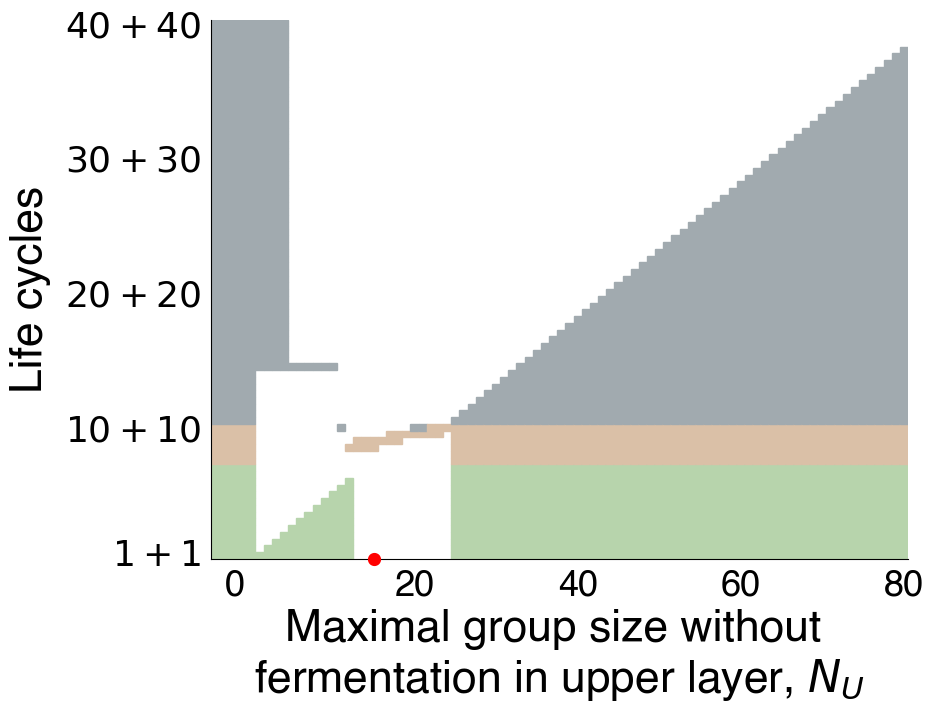

In [12]:
# Plotting

df=pd.read_csv("Data/Data_Cell_n2n2/Cell_results_N2N2.csv",header=None)
M_l=[]
for i in range(81):
    x=df.T[i].to_numpy()
    x[x==100]=-1
    x[x>=80]=np.nan
    x[x==-1]=80
    M_l.append(x[~np.isnan(x)])


fig, ax = pl.subplots(figsize=(9, 7))

hfont = {'fontname':'Helvetica'}




for i in range(len(M_l)):
    df=pd.read_csv("Data/Data_Cell_n2n2/Cells_K_"+str(i)+"_"+str(rF)+".csv")
    K_up=df["K_A"].to_numpy()
    K_low=df["K_B"].to_numpy()
    for j in M_l[i]:
        if j<15: # Small life cycle
            if i==0:
                ax.fill([i-5,i-5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#b7d4acff')
            else:
                ax.fill([i-0.5,i-0.5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#b7d4acff')
        elif K_up[int(j)]>K_low[int(j)]: # Intermediate life cycle
            if i==0:
                ax.fill([i-5,i-5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#dac0a7ff')
            else:
                ax.fill([i-0.5,i-0.5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#dac0a7ff')
        elif K_up[int(j)]<=K_low[int(j)]: # Large life cycle
            if i==0:
                ax.fill([i-5,i-5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#a1aaafff')
            else:
                ax.fill([i-0.5,i-0.5,i+0.5,i+0.5], [j-0.5,j+0.5,j+0.5,j-0.5], color='#a1aaafff')


ax.scatter([15],[0.5],lw=4,c='r',alpha=1,zorder=10,clip_on=False, s=30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(-5,80.5)
ax.set_ylim(0.5,80.5)

ax.set_xticks([-2,20,40,60,80])
ax.set_yticks([1.5,20,40,60,80])

ax.set_xticklabels([0,20,40,60,80])
ax.set_yticklabels([r'$1+1$',r'$10+10$',r'$20+20$',r'$30+30$',r'$40+40$'])

#pl.text(-14, 80.5, r'$(N \to \infty)$', fontsize=20)


pl.tick_params(left = False)
pl.tick_params(bottom = False)
ax.tick_params(labelsize=26)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")

ax.set_ylabel('Life cycles',fontsize=32,rotation=90,labelpad=10,multialignment='center',**hfont)
ax.set_xlabel('Maximal group size without \nfermentation in upper layer, $N_U$',fontsize=32,multialignment='center',**hfont)

pl.show()


fig.savefig(r"Figures/NpN.png",bbox_inches='tight')
fig.savefig(r"Figures/NpN.svg",bbox_inches='tight')
fig.savefig(r"Figures/NpN.pdf",bbox_inches='tight')